## Binary Classification of Protein Interaction

## _**Abstract**_
Protein complexes consist of two or more polypeptide chains. However, predicting the entire complex and the order of chains poses a challenge. In some cases, the complexes are too large to be processed by structure prediction software like AlphaFold. Additionally, when chains are homologous (having a common evolutionary origin), the software struggles to distinguish between them.

In this project, we aimed to generate predictions for all possible pairs of chains (dimers) within protein structures. Subsequently, we developed a model to classify interacting and non-interacting pairs, enabling us to progressively construct the complete complex in the correct order.

Our model focuses on the human 20s Proteasome protein complex (PDB ID:5LE5), which consists of 14 distinct chains.

## Dataset
The dataset is sourced from the PDB database and comprises 298 protein complexes. Each complex contains only homologous chains, which can range from 2 to 14 types. By considering all possible combinations of pairs within the complexes, we generated 1400 pairs and predicted their structures and interactions using AlphaFold-multimer.

For each prediction, three types of data were extracted:
1. Scores indicating the confidence of the structure and interaction.
2. Information about the residues involved in the interaction (the binding mode/interface of each chain in the dimer).
3. The quality of the prediction, measuring the similarity between the predicted and actual pairs for interacting pairs.

### Challenge
Our target variable is the number of residues in contact for the actual pairs. The number of residues in contact indicates the proximity and interaction between the chains. Determining how many residues are sufficient for a pair to be considered interacting is challenging, as it depends on multiple factors. A constant number cannot be universally applied to all complexes.

## **Workflow** 
### Data processing and filtering. 
1. Redundancy was eliminated using the PDB filter.
2. Scores irrelevant to interaction classification are removed.
3. The train-test split was performed based on structures rather than pairs. This approach prevents learning leakage from pairs in the training set that belong to the same structure as pairs in the test set.
4. Scaling/Normalization: Various scaling and normalization techniques were examined, as outlined below:
    1. A MinMax scale was fit to the training data and applied to both the training and test sets.
    2. The MinMax scale was applied to pairs within each structure individually, where each structure has its maximum and minimum values.
    3. The MinMax scale was applied within each structure, but the scores were ranked before scaling. This approach neutralizes differences, ensuring that scores such as 0.1, 0.2, and 0.8 are considered equivalent to 0.8, 0.9, and 0.91.
    
  >*Among these approaches, the third method demonstrated the best performance.*


### Model building 
Due to the challenge of using a continuous, non-binary target variable for binary classification, both classification and regression models were explored:
1. A threshold of a minimum of 10 residues was set to classify pairs as interacting. This threshold was chosen based on the specific context of the human 20s proteasome, which is the final goal of the project. The target variable "obs_contact" was converted to binary form.
2. A two-step approach was implemented:
    1. Unsupervised clustering, along with the elbow method, was utilized on the information about residues involved in interaction (interface residues) to group the pairs.
    2. A regression model was created without converting the target variable to binary, yielding a final score indicating the likelihood of a pair being classified as interacting.
 
  Finally, the regression model was used to rank the pairs within each cluster. The first-ranked pair was classified as interacting, while the others were classified as non-interacting.
>*The second approach demonstrated the best performance*

### Conclusion.
The final results aim to address the following questions: 
1. Can we construct the interaction graph of the complex based on pairwise predictions?
2. Does this interaction graph accurately represent the correct structure?

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef,pairwise_distances, accuracy_score, silhouette_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import pickle

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from scipy.signal import find_peaks
from kneed import KneeLocator

import ast

# 1. Importing the dataset and filtering

In [63]:
df = pd.read_csv('final.txt')
df['pdb_id'] = df['pair'].apply(lambda x: x.split('_')[0])
df = df.rename(columns={'pdockq1': 'pdockq2', 'pdockq2': 'pdockq1'}) # The names are swithed ( I didn't want to make any change in my csv file)
df

,IntraclashesGroup1,IntraclashesGroup2,Interaction Energy,Backbone Hbond,Sidechain Hbond,Van der Waals,Electrostatics,Solvation Polar,Solvation Hydrophobic,Van der Waals clashes,...,Interface Residues Clashing,Interface Residues VdW Clashing,Interface Residues BB Clashing,pair,obs_contact,pred_contact,pdockq2,pdockq1,ptm_iptm,pdb_id
0,161.1480,147.7570,45.52850,-2.912110,-1.583120,-18.9095,-1.254490,28.7354,-23.6758,48.74650,...,8,8,0,7LXB_A_7LXB_A,0,62,0.463,0.048,0.687,7LXB
1,20.2037,21.2937,-13.88220,-2.945230,-4.395080,-16.7192,-0.819818,17.1747,-22.4982,7.80684,...,4,4,0,1J40_B_1J40_B,0,55,0.668,0.894,0.904,1J40
2,38.4498,27.1958,-5.45750,-1.509110,-3.684430,-12.4962,-1.353160,15.2023,-16.6327,5.20689,...,0,0,0,1I85_A_1I85_C,43,42,0.578,0.816,0.907,1I85
3,41.7438,59.2396,20.59240,-0.944800,-0.049244,-11.8596,-2.163300,17.8063,-14.0309,22.91030,...,9,9,0,5LE5_C_5LE5_K,17,24,0.319,0.101,0.664,5LE5
4,269.5290,263.5870,-24.74730,-4.892230,-3.232880,-40.8127,-0.203678,41.6916,-59.3824,14.45860,...,0,0,0,3WJM_A_3WJM_A,34,143,0.714,0.547,0.874,3WJM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,512.4600,407.4030,114.44500,-4.234760,-4.948420,-44.4537,-3.952810,66.0537,-57.9259,119.23900,...,21,21,2,3JA8_6_3JA8_7,10,192,0.635,0.046,0.541,3JA8
1366,120.3540,95.9941,-15.86760,-8.884760,-7.227820,-33.6246,-7.453950,47.3403,-47.0027,14.75810,...,3,3,0,6MAF_A_6MAF_D,31,107,0.660,0.531,0.851,6MAF
1367,21.5211,17.7560,-1.23862,-2.769320,-2.834000,-13.1870,-2.742180,18.7282,-17.3493,9.92608,...,4,4,0,2D1P_A_2D1P_B,46,43,0.629,0.899,0.906,2D1P
1368,22.8690,54.7237,-7.25703,-0.781466,-1.644370,-14.0024,0.709530,15.3692,-19.6138,5.64588,...,2,2,0,6OL7_B_6OL7_C,65,52,0.640,0.930,0.887,6OL7


#### **Target Variable and Structures**
Let's analyze the ```obs_contact``` column to evaluate the interaction status and its relationship with the size of the structures.
> **Whenever we convert the target variable to binary, we utilize a threshold of 10**
 

In [64]:
# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pair']
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
structures = df2['pdb_id'].unique()
df2['number_of_chains'] = [len(set(df2[df2['pdb_id']==i]['chain1']).union(set(df2[df2['pdb_id']==i]['chain2']))) for i in df2['pdb_id']]
df2['obs_contact']=df['obs_contact']
df2['number_of_contacts'] = [len(df2[(df2['pdb_id']==i) & (df2['obs_contact']>10)]) for i in df2['pdb_id']]
df2['ratio']=df2['number_of_contacts']/df2['number_of_chains']
df2

,pair,chain1,chain2,pdb_id,number_of_chains,obs_contact,number_of_contacts,ratio
0,7LXB_A_7LXB_A,A,A,7LXB,2,0,1,0.500000
1,1J40_B_1J40_B,B,B,1J40,2,0,1,0.500000
2,1I85_A_1I85_C,A,C,1I85,2,43,3,1.500000
3,5LE5_C_5LE5_K,C,K,5LE5,14,17,34,2.428571
4,3WJM_A_3WJM_A,A,A,3WJM,2,34,2,1.000000
...,...,...,...,...,...,...,...,...
1365,3JA8_6_3JA8_7,6,7,3JA8,6,10,6,1.000000
1366,6MAF_A_6MAF_D,A,D,6MAF,2,31,3,1.500000
1367,2D1P_A_2D1P_B,A,B,2D1P,3,46,6,2.000000
1368,6OL7_B_6OL7_C,B,C,6OL7,4,65,6,1.500000


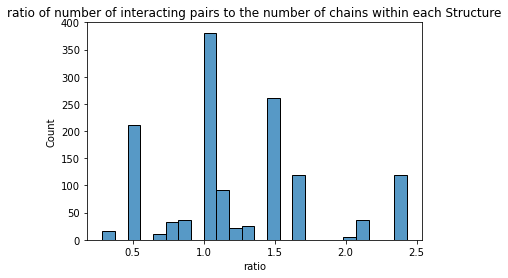

In [51]:
grouped = df2.groupby('pdb_id').mean()
sns.histplot(df2['ratio'])
plt.title('ratio of number of interacting pairs to the number of chains within each Structure')
plt.show()

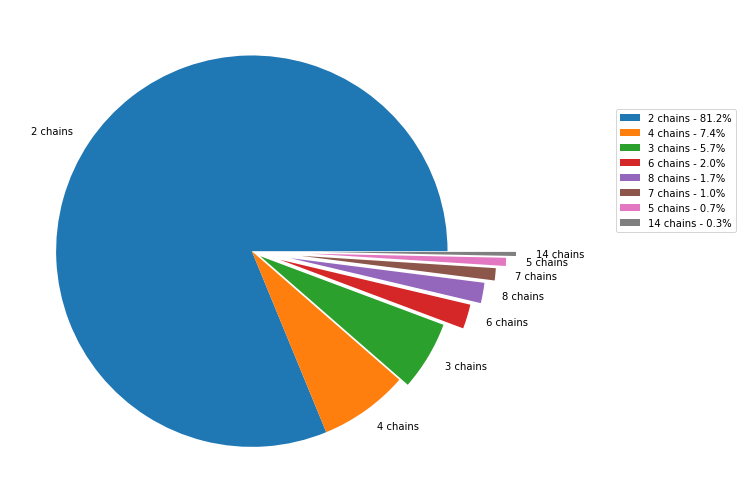

In [52]:
chain_count_dic={}
for st in structures:
    for _,row in df2.iterrows():
        if row['pdb_id']==st:
            chain_count_dic[st]=row['number_of_chains']
            break
chain_count_dic2={}
for st in chain_count_dic:
    if '%d chains'%chain_count_dic[st] in chain_count_dic2:
        chain_count_dic2['%d chains'%chain_count_dic[st]]+=1
    else:
        chain_count_dic2['%d chains'%chain_count_dic[st]]=1
chain_count_dic2=dict(sorted(chain_count_dic2.items(), key=lambda x: x[1], reverse=True))
# Create the pie plot
plt.figure(figsize=(9, 9))
explode=(0,0.0,0.05,0.15,0.2,0.25,0.3,0.35)
plt.pie(chain_count_dic2.values(), labels=chain_count_dic2.keys(), explode=explode) #autopct='%1.1f%%'
plt.legend(frameon=True, 
          bbox_to_anchor=(1.5,0.8), 
          labels=['%s - %1.1f%%' % (l, s/np.sum(list(chain_count_dic2.values()))*100) for l, s in zip(list(chain_count_dic2.keys()), chain_count_dic2.values())]
         )
# Add a title
#plt.title('Distribution of Structures by Chain Count')

# Display the plot
plt.show()

Text(0.5, 0, 'Residues in Contact')

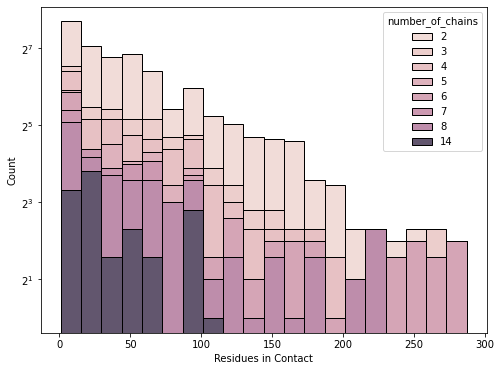

In [27]:
plt.figure(figsize=(8, 6))
plt.yscale('log',base=2)
sns.histplot(data=df2[(df2.obs_contact<300) & (df2.obs_contact>0)], x="obs_contact", hue="number_of_chains", multiple="stack")
plt.xlabel('Residues in Contact')

# 2. Inspecting data
**Which scores are irrelevant to obs_contact column?**

We classified the "obs_contact" into three ranges:
1. 0, indicating 100% non-interacting pairs.
2. 1-9, representing pairs that could be interacting or not.
3. More than 9, indicating 100% interacting pairs.


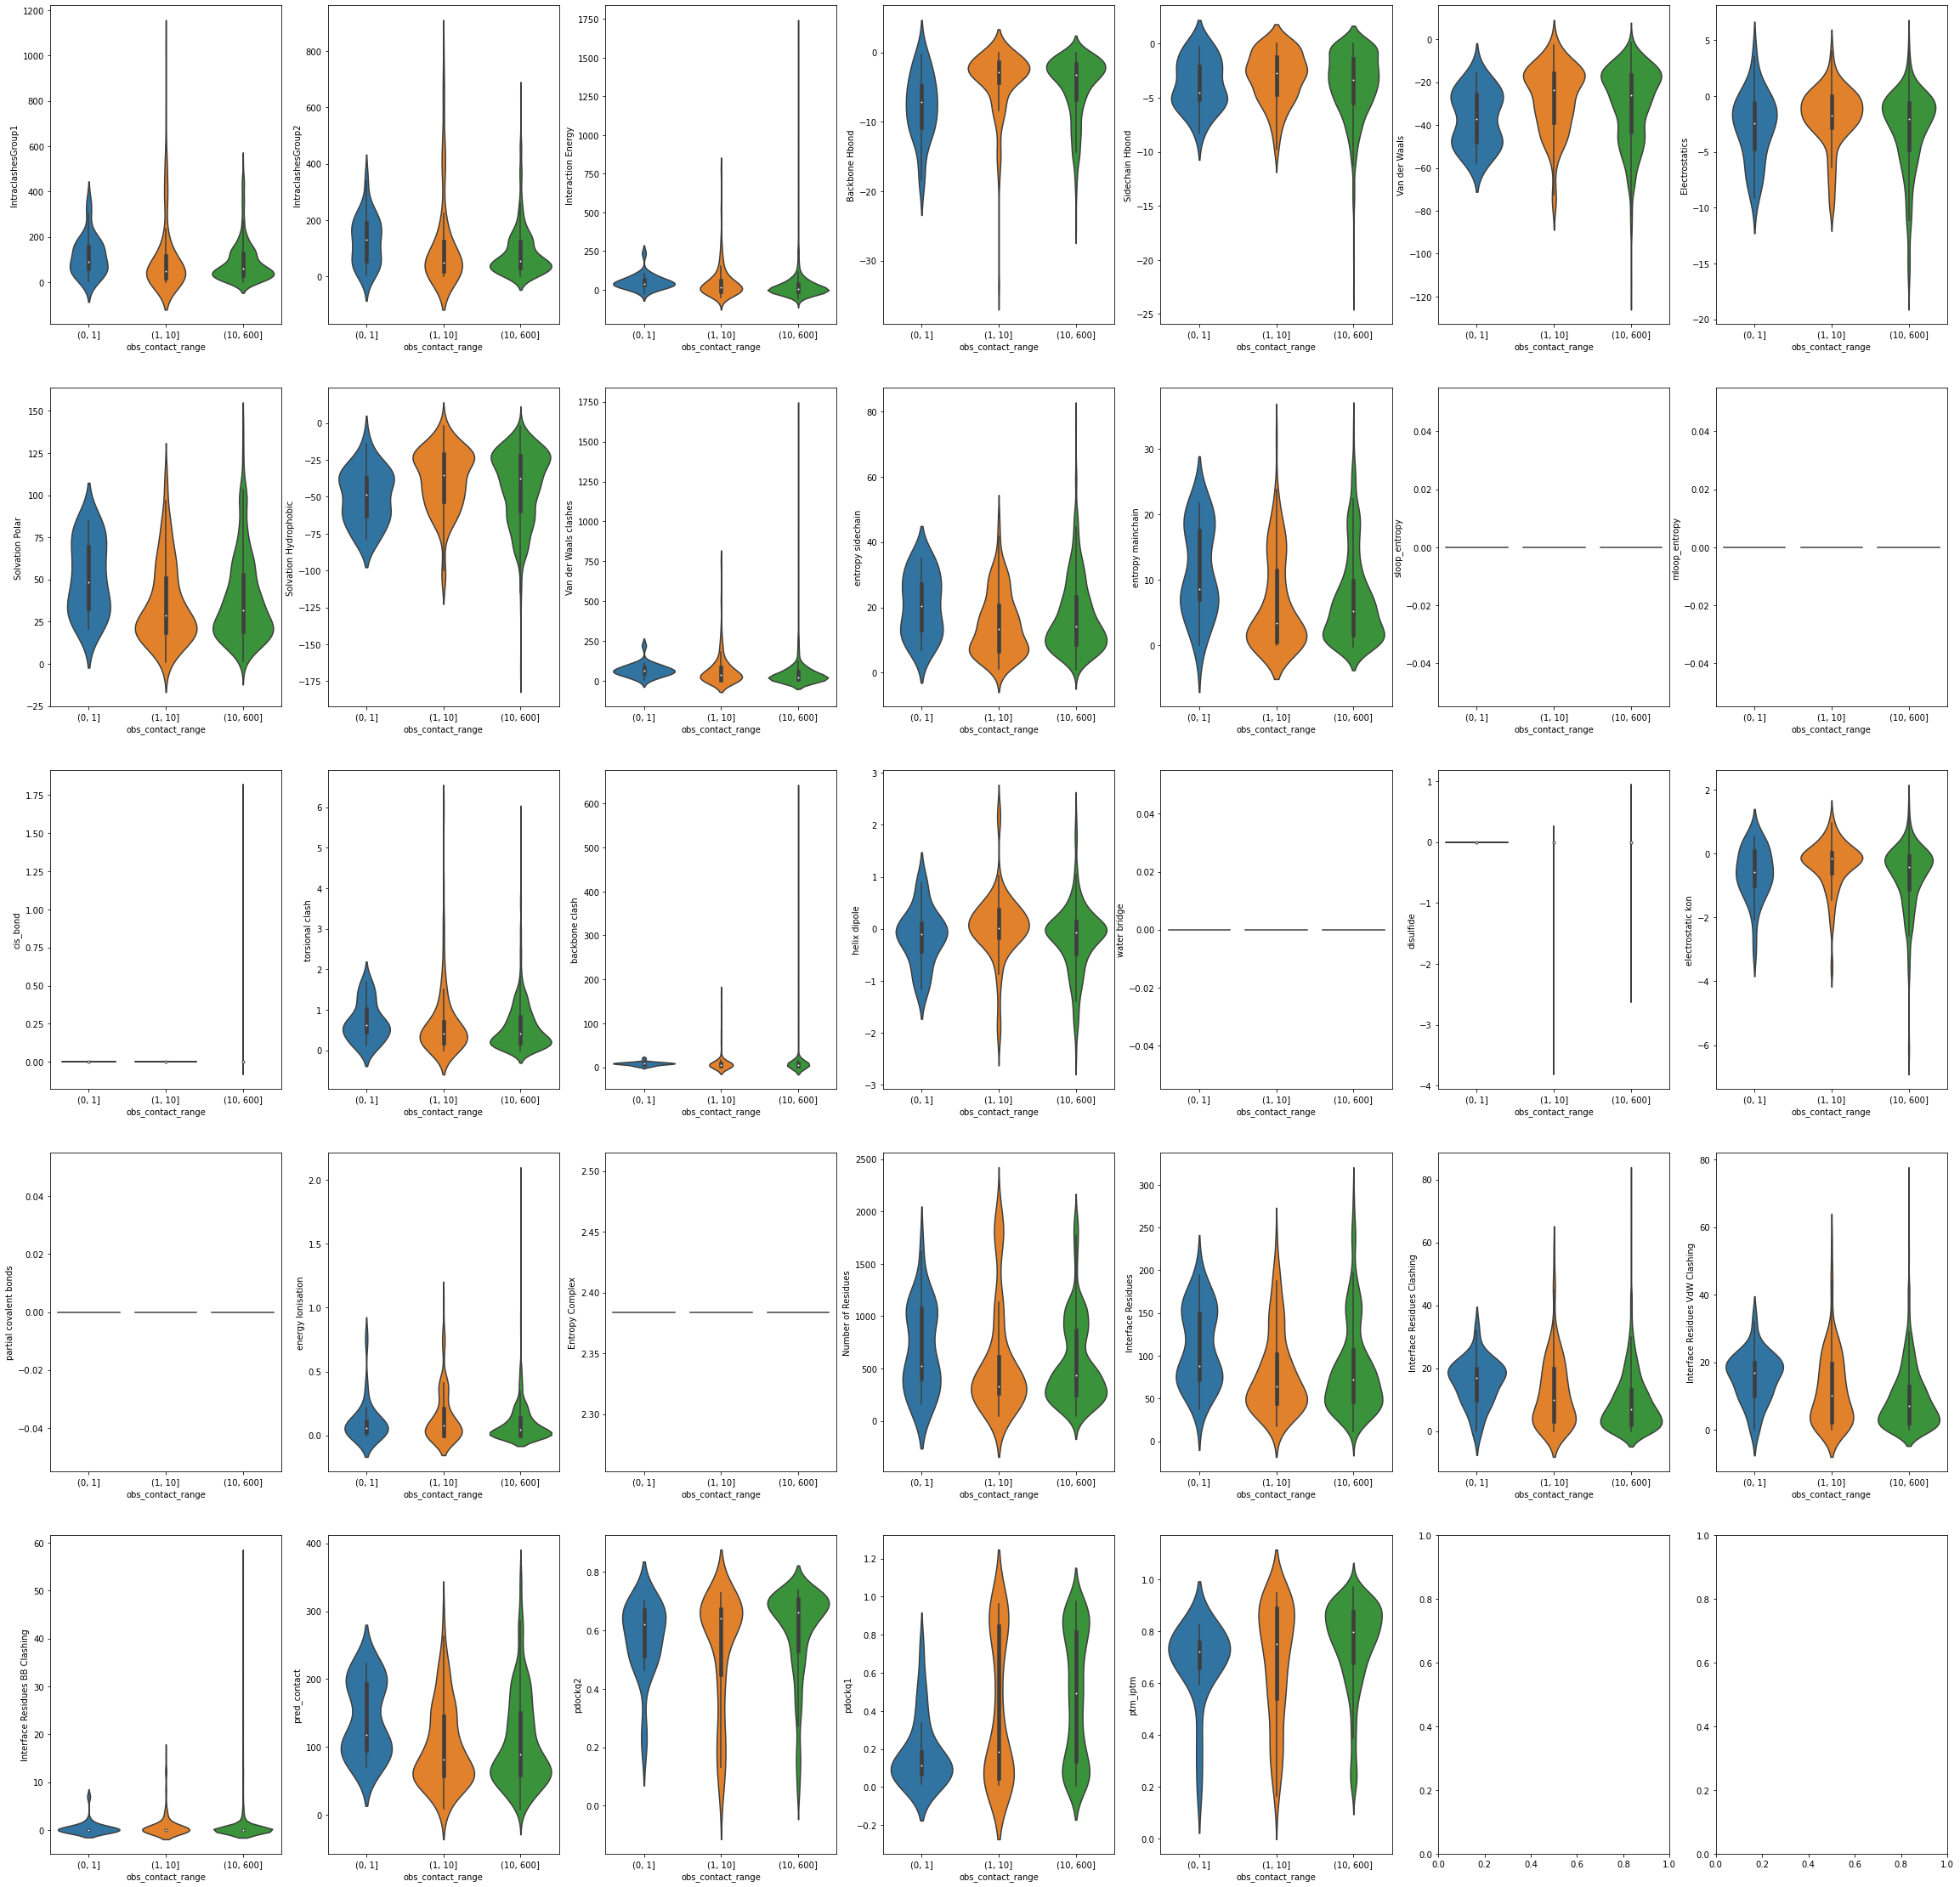

In [21]:
f,axs=plt.subplots(5,7,figsize=(40,40))
df['obs_contact_range'] = pd.cut(df['obs_contact'], [0, 1, 10, 600])
for i,feature in enumerate(df.drop(['pair', 'pdb_id', 'obs_contact','obs_contact_range'], axis=1).columns):
    row = i // 7
    col = i % 7
    ax = axs[row, col]
    sns.violinplot(x='obs_contact_range', y=feature, data=df, ax=ax)

# 3. Thresholding-based feature evaluation
Performance Evaluation of Individual Features Using Thresholding and Comparison to a Random generated Feature.

The whole process is done for three different threshold to make binary target variable; 0, 10 and 20.


In [3]:
# MCC score calculator to handle zero denominator
def get_tp_tn_fp_fn(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn
def safe_mcc(y_true, y_pred):
    eps = np.finfo(np.float64).eps # smallest representable positive number
    tp, tn, fp, fn = get_tp_tn_fp_fn(y_true, y_pred) # function to calculate tp, tn, fp, fn
    denom = np.sqrt((tp + fp + eps) * (tp + fn + eps) * (tn + fp + eps) * (tn + fn + eps))
    return (tp * tn - fp * fn) / denom

In [55]:
thresholds_features_dic = {}
for threshold in [0,10,20]:
    df['binary_obs_contact'] = np.where(df['obs_contact'] > threshold, 1, 0)  # change here if necessary

    ranked_df=pd.DataFrame()

    # Make it binary by setting a threshold and split training and test
    ranked_df['binary_obs_contact'] = df['binary_obs_contact']

    # Generate a random feature
    ranked_df['random1'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random2'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random3'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random4'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random5'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random6'] = np.random.randint(low=1, high=1370, size=1370)
    ranked_df['random7'] = np.random.randint(low=1, high=1370, size=1370)

    features_dic = {}
    thresholds_dic = {}
    for feature in ['random1','random2','random3','random4','random5','random6','random7',\
                    'IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
           'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
           'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
           'entropy sidechain', 'entropy mainchain', 'sloop_entropy',
           'mloop_entropy', 'cis_bond', 'torsional clash', 'backbone clash',
           'helix dipole', 'water bridge', 'disulfide', 'electrostatic kon',
           'partial covalent bonds', 'energy Ionisation', 'Entropy Complex',
           'Number of Residues', 'Interface Residues',
           'Interface Residues Clashing', 'Interface Residues VdW Clashing',
           'Interface Residues BB Clashing', 'pred_contact',
           'pdockq1', 'pdockq2', 'ptm_iptm']:

        if feature[:6] != 'random':
            ranked_df[feature] = df[feature].rank()

        # Check the correlation
        if np.corrcoef(ranked_df['binary_obs_contact'],ranked_df[feature])[0][1] > 0:
            # Compute F1 score for different threshold values
            thresholds = [i for i in range(1, 1370)]
            f1_scores = []
            for t in thresholds:
                y_pred_binary = (ranked_df[feature] >= t).astype(int)
                MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
                f1_scores.append(MCC)
            # Find the threshold that maximizes F1 score
            best_threshold = thresholds[f1_scores.index(max(f1_scores))]
            y_pred_binary = (ranked_df[feature] >= best_threshold).astype(int)
            #print (feature)
            #print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
            #print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
            #print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
            #print("Best threshold:", best_threshold)
            #print("Best macro f1:", max(f1_scores))
            #print ('\n')
            thresholds_dic[feature]=[best_threshold,1]

        else:
            # Compute F1 score for different threshold values
            thresholds = [i for i in range(1, 1370)]
            f1_scores = []
            for t in thresholds:
                y_pred_binary = (ranked_df[feature] <= t).astype(int)
                MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
                f1_scores.append(MCC)
            # Find the threshold that maximizes F1 score
            best_threshold = thresholds[f1_scores.index(max(f1_scores))]
            y_pred_binary = (ranked_df[feature] <= best_threshold).astype(int)
            #print (feature)
            #print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
            #print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
            #print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
            #print("Best threshold:", best_threshold)
            #print("Best macro f1 score:", max(f1_scores))
            #print ('\n')
            thresholds_dic[feature]=[best_threshold,-1]
        features_dic[feature]=safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)

    features_dic['random']=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3'],features_dic['random4'],features_dic['random5'],features_dic['random6'],features_dic['random7']])
    del features_dic['random1']; del features_dic['random2']; del features_dic['random3']; del features_dic['random4']; del features_dic['random5']; del features_dic['random6']; del features_dic['random7']
    thresholds_features_dic[threshold]=features_dic

O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
O:\anaconda3\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


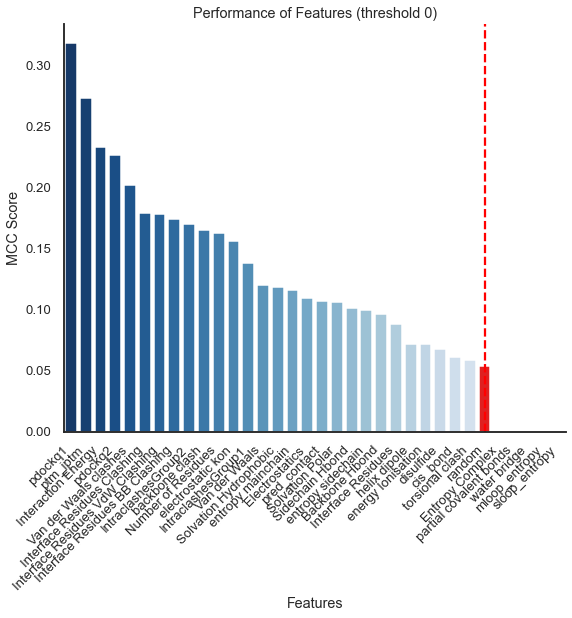

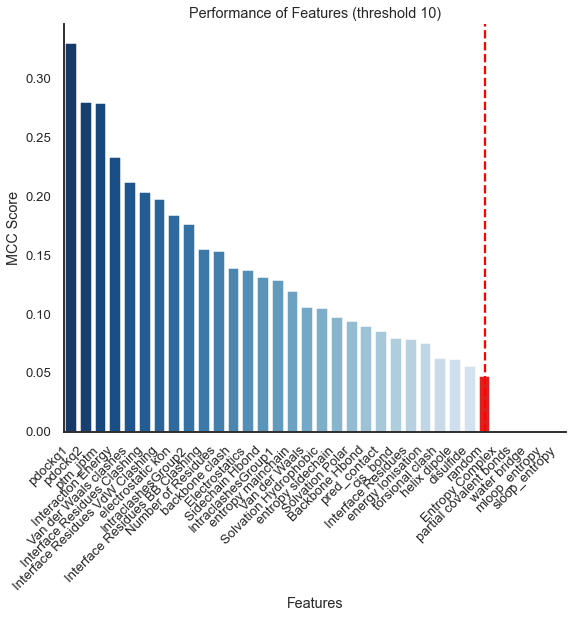

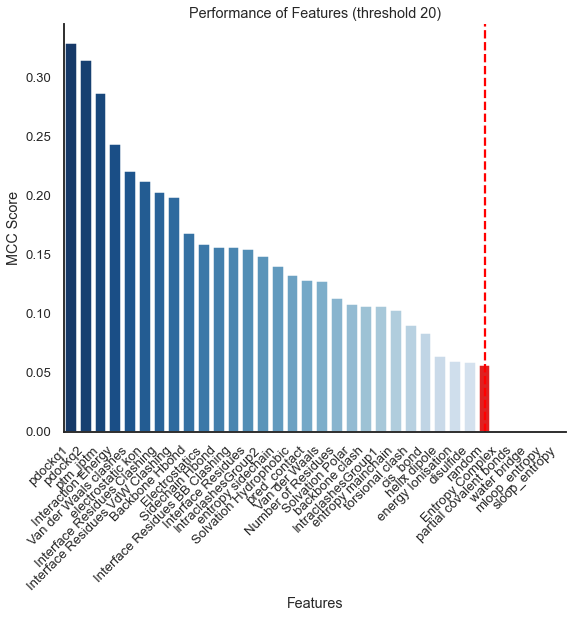

In [56]:
for threshold,dic in thresholds_features_dic.items():
    #random=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3']])
    #del features_dic['random1']; del features_dic['random2']; del features_dic['random3'];

    # Convert the dictionary into a Pandas DataFrame and sort by value in descending order
    df_tmp = pd.DataFrame(list(dic.items()), columns=["Features", "Values"]).sort_values(by="Values", ascending=False)

    # Set the x-axis label and rotate the labels for better visibility
    sns.set(rc={'figure.figsize':(9,7.5)})
    sns.set_style('white')
    sns.set_context('talk', font_scale=0.8)

    # Set the color palette with red for "random" feature and blues_r for others
    palette = {"random": "red"}
    other_palette = sns.color_palette("Blues_r", len(df_tmp))
    for i, feature in enumerate(df_tmp["Features"].tolist()):
        if feature != "random":
            palette[feature] = other_palette[i]

    # Create the bar plot
    ax = sns.barplot(x="Features", y="Values", data=df_tmp, order=df_tmp["Features"], palette=palette)
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("MCC Score")
    plt.title('Performance of Features (threshold %d)'%threshold)

    # Add a vertical dashed red line at the location of the "random" bar
    random_index = np.where(df_tmp["Features"]=="random")[0][0]
    ax.axvline(x=random_index, color="red", linestyle="--")

    plt.show()

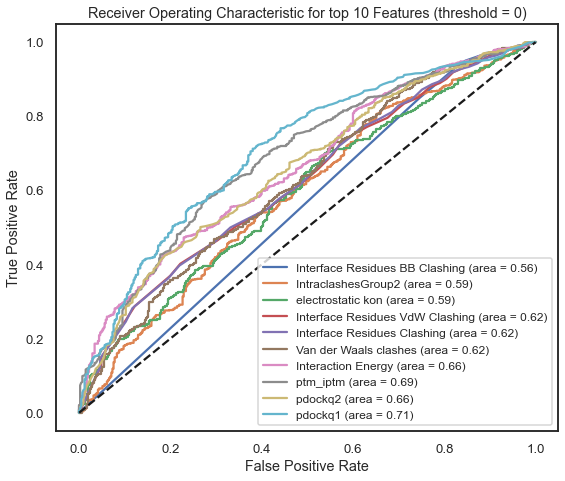

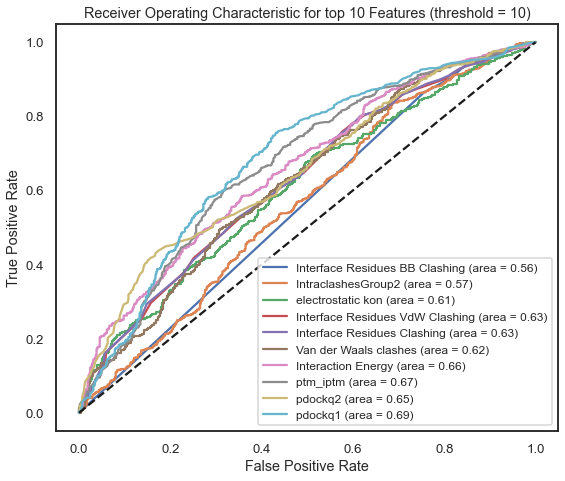

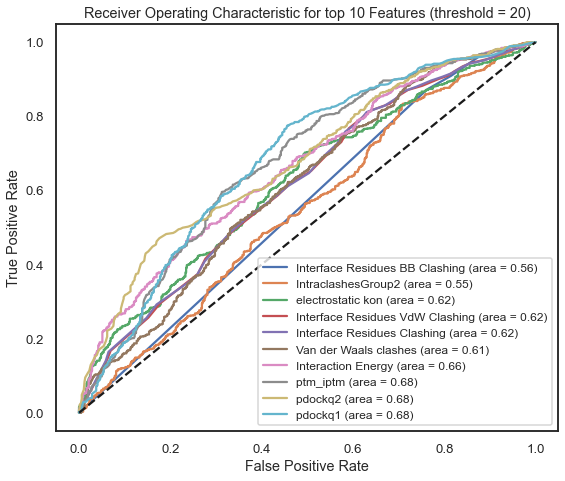

In [11]:
for threshold in [0,10,20]:
    best_features = sorted(thresholds_features_dic[10],key=lambda x: thresholds_features_dic[10][x])[-10:]
    df['binary_obs_contact'] = np.where(df['obs_contact'] > threshold, 1, 0)

    plt.figure()
    for feature in best_features:
        ranked_df[feature] = df[feature].rank()

        if np.corrcoef(ranked_df['binary_obs_contact'],ranked_df[feature])[0][1] > 0:
            fpr, tpr, _ = roc_curve(df['binary_obs_contact'], ranked_df[feature])
            roc_auc = auc(fpr, tpr)
        else:
            ranked_df[feature]=ranked_df[feature]*(-1)
            fpr, tpr, _ = roc_curve(df['binary_obs_contact'], ranked_df[feature])
            roc_auc = auc(fpr, tpr)    
        plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (feature,roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for top 10 Features (threshold = %d)'%threshold)
    plt.legend(loc='lower right',fontsize='small')
    plt.show()

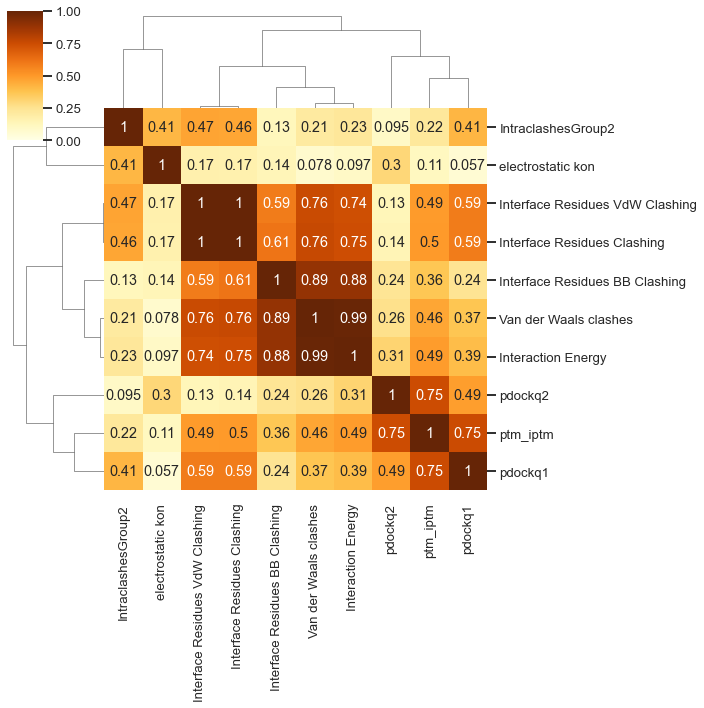

In [13]:
df = df.drop(['obs_contact_range','binary_obs_contact'],axis=1)

best_features = sorted(thresholds_features_dic[10],key=lambda x: thresholds_features_dic[10][x])[-10:]

# Calculate the correlation matrix between the features
corr_matrix = np.abs(np.corrcoef(df[best_features], rowvar=False))

# Create a hierarchical clustering plot using Seaborn
sns.clustermap(corr_matrix, cmap="YlOrBr", xticklabels=df[best_features].columns, yticklabels=df[best_features].columns, annot=True, figsize=(10, 10), vmin=0, vmax=1)

**Using domain knowledge, as well as previous plots and studies, We selected the final features.**

In [65]:
selected_features = ['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'ptm_iptm',
       'pdockq2', 'pdockq1', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing', 'electrostatic kon',
       'Interface Residues BB Clashing', 'Interface Residues VdW Clashing','obs_contact'] #'Number of Residues'

# 4.  Scaling
**Structure-based Ranked Min-Max scaling is applied to all features. However, for the target variable 'obs_contact', ranking is not performed.**


In [66]:
def just_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]-df[feature]+0.5
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

In [67]:
# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pair']
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])

df2[selected_features]=df[selected_features]

for feature in selected_features:
    if feature in ['pred_contact','pdockq2', 'pdockq1','ptm_iptm']:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))
    elif feature in ['obs_contact']:
        df2 = df2.groupby('pdb_id').apply(lambda x: just_minmaxscale(x, feature))
    else:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))

Text(0.5, 0, 'Contact Residues Count (MinMax Scale)')

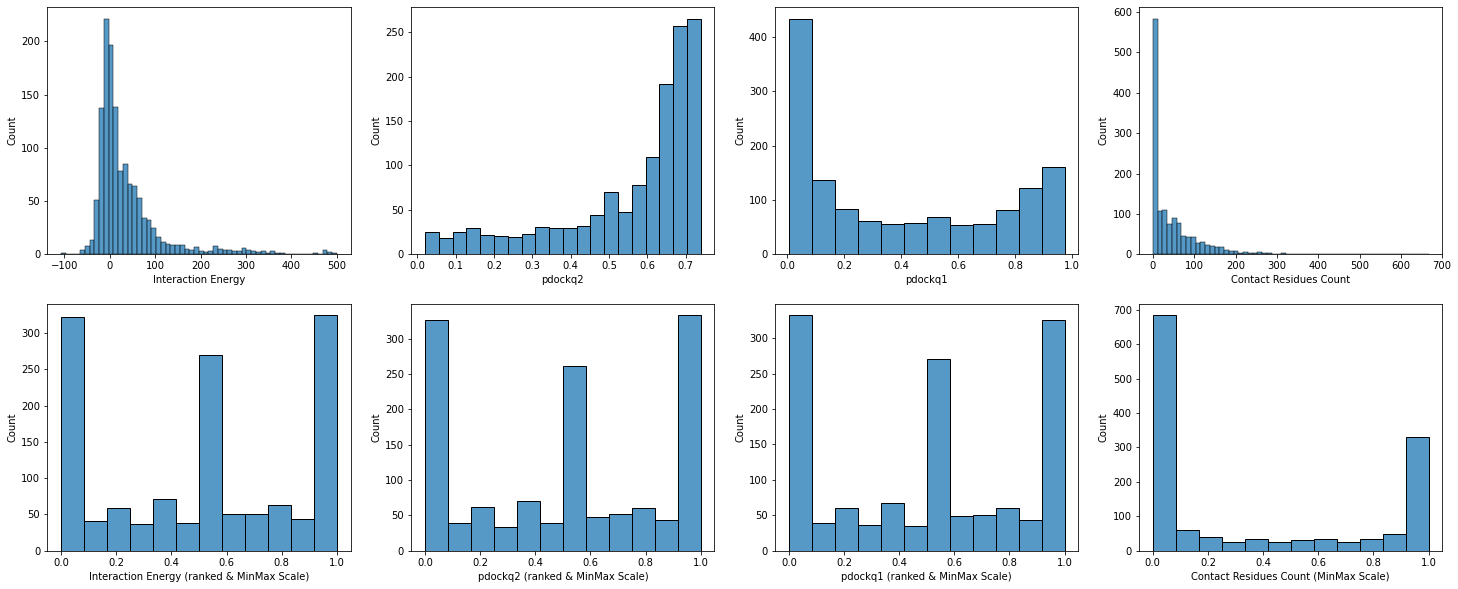

In [68]:
#df2[df2.pair.str.contains('5LE5')].sort_values(by=['pair'])[['pair','pred_contact','pdockq2','Interaction Energy','obs_contact']]
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(25,10))
sns.histplot(df['Interaction Energy'],ax=axes[0,0], binrange=(-107,500))
sns.histplot(df2['Interaction Energy'],ax=axes[1,0])
axes[1, 0].set_xlabel('Interaction Energy (ranked & MinMax Scale)')
sns.histplot(df.pdockq2,ax=axes[0,1])
sns.histplot(df2.pdockq2,ax=axes[1,1])
axes[1, 1].set_xlabel('pdockq2 (ranked & MinMax Scale)')
sns.histplot(df.pdockq1,ax=axes[0,2])
sns.histplot(df2.pdockq1,ax=axes[1,2])
axes[1, 2].set_xlabel('pdockq1 (ranked & MinMax Scale)')
sns.histplot(df.obs_contact,ax=axes[0,3])
axes[0, 3].set_xlabel('Contact Residues Count')
sns.histplot(df2.obs_contact,ax=axes[1,3])
axes[1, 3].set_xlabel('Contact Residues Count (MinMax Scale)')

# 5.  ANN Regression Model

1. Splitting the dataset into training and test sets based on protein structure.
2. Ensuring that the training set does not include the Human 20s Proteosome (5LE5) protein structure.
3. Ensuring that there is no bias in the distribution of training and test structures, and that their sizes are evenly distributed.

In [69]:
# Train and Test set
train_ids, test_ids = train_test_split(df2['pdb_id'].unique(), test_size=0.2, random_state=40)
X_train = df2[df2.pdb_id.isin(train_ids)].drop(['pdb_id','chain1','chain2','obs_contact', 'pair'], axis=1) # features
X_test = df2[df2.pdb_id.isin(test_ids)].drop(['pdb_id','chain1','chain2','obs_contact', 'pair'], axis=1) # features
y_train = df2[df2.pdb_id.isin(train_ids)]['obs_contact'] # Target variable
y_test = df2[df2.pdb_id.isin(test_ids)]['obs_contact'] # Target variable
if '5LE5' in test_ids:
    print ('20s proteosome is not in training IDs')

20s proteosome is not in training IDs


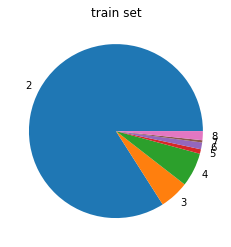

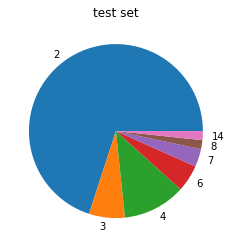

In [34]:
chain_count_dic={}
for pdb in df2['pdb_id'].unique():
    chain_count_dic[pdb]=len(set(df2[df2['pdb_id']==pdb]['chain1']).union(set(df2[df2['pdb_id']==pdb]['chain2'])))

train_dict = {key: value for key, value in chain_count_dic.items() if key in train_ids}
chain_counts = list(set(train_dict.values()))
counts = [list(train_dict.values()).count(count) for count in chain_counts]
plt.pie(counts, labels=chain_counts) #, autopct='%1.1f%%'
plt.title("train set")
plt.show()
test_dict = {key: value for key, value in chain_count_dic.items() if key in test_ids}
chain_counts = list(set(test_dict.values()))
counts = [list(test_dict.values()).count(count) for count in chain_counts]
plt.pie(counts, labels=chain_counts)
plt.title("test set")
plt.show()

The **ANN architecture** consists of an input layer, two hidden layers with ReLU activation, and an output layer. Dropout layers are used for regularization. The model is trained using MAE loss and optimized with the Adam optimizer.

In [94]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(X_train.columns)))
model.add(Dropout(0.3))  # Dropout rate to 0.3
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Added an additional hidden layer with regularization
model.add(Dropout(0.7))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Changed the optimizer to Adam with a lower learning rate
model.compile(optimizer=optimizer, loss='mae') # 100% sure works better than MSE

# Train the model
model.fit(X_train, y_train, epochs=20, verbose=0, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)
print ('Model')
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))

print ('Baseline')
# make a baseline model
y_mean = np.mean(y_train)  # y_train is the target variable in the training data
y_pred_baseline = np.full((len(X_test),), y_mean)
print('MSE: ', mean_squared_error(y_test, y_pred_baseline))
print('R2 score: ', r2_score(y_test, y_pred_baseline))

14/14 [==============================] - 0s 1ms/step
Model
MSE:  0.10149244651950304
R2 score:  0.3163774440379987
Baseline
MSE:  0.1608389845439279
R2 score:  -0.08336296426871481


After obtaining predictions from the model, the output is converted back to the original scale of 'obs_contact' values. This conversion is performed to ensure that the predicted values align with the unscaled values of the target variable. By reverting the scaling, we can interpret the model's predictions in the same context as the original 'obs_contact' values.

### Overall Performance

58 = False Positives
50 = False Negatives
147 = True Positives
164 = True Negatives
0.48 = MCC_score
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       222
           1       0.72      0.75      0.73       197

    accuracy                           0.74       419
   macro avg       0.74      0.74      0.74       419
weighted avg       0.74      0.74      0.74       419



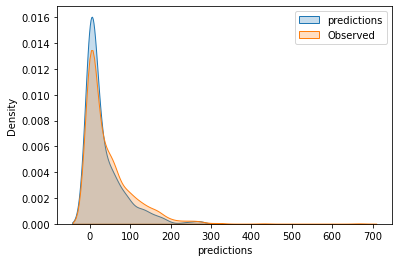

In [90]:
y_test2 = pd.merge(y_test, df2[['pair','pdb_id']], left_index=True, right_index=True)
y_test2 = pd.merge(y_test2, df['obs_contact'], left_index=True, right_index=True)
y_test2['predictions'] = y_pred

for index,row in y_test2.iterrows():
    ID = row['pdb_id']
    maximum = max(df[df['pair'].str.contains(ID)]['obs_contact'])
    minimum = min(df[df['pair'].str.contains(ID)]['obs_contact'])
    if minimum==maximum: continue
    y_test2.loc[index,'obs_contact_x'] = y_test2.loc[index,'obs_contact_x']*(maximum-minimum)+minimum
    y_test2.loc[index,'predictions'] = y_test2.loc[index,'predictions']*(maximum-minimum)+minimum
sns.kdeplot(y_test2['predictions'], shade=True, label='predictions')
sns.kdeplot(df['obs_contact'], shade=True, label='Observed')
#sns.kdeplot(y_test2['obs_contact_y'], shade=True, label='Observed')
plt.legend()

binary_true = np.where(y_test2['obs_contact_y'] > 10, 1, 0)
binary_pred = np.where(y_test2['predictions'] > 10, 1, 0)
CM = confusion_matrix(binary_true,binary_pred)
FP_count = CM[0,1]
TP_count = CM[1,1]
FN_count = CM[1,0]
TN_count = CM[0,0]
print (FP_count,'= False Positives')
print (FN_count,'= False Negatives')
print (TP_count,'= True Positives')
print (TN_count ,'= True Negatives')

print(round(matthews_corrcoef(binary_true,binary_pred),2),'= MCC_score')
print(classification_report(binary_true,binary_pred))

### 5LE5 Performance

19 = False Positives
6 = False Negatives
28 = True Positives
52 = True Negatives
0.52 = MCC_score
              precision    recall  f1-score   support

           0       0.90      0.73      0.81        71
           1       0.60      0.82      0.69        34

    accuracy                           0.76       105
   macro avg       0.75      0.78      0.75       105
weighted avg       0.80      0.76      0.77       105



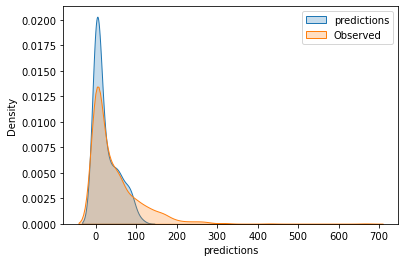

In [95]:
y_test2 = pd.merge(y_test, df2[['pair','pdb_id']], left_index=True, right_index=True)
y_test2 = pd.merge(y_test2, df['obs_contact'], left_index=True, right_index=True)
y_test2['predictions'] = y_pred
y_test2=y_test2[y_test2['pdb_id']=='5LE5']

for index,row in y_test2.iterrows():
    ID = row['pdb_id']
    maximum = max(df[df['pair'].str.contains(ID)]['obs_contact'])
    minimum = min(df[df['pair'].str.contains(ID)]['obs_contact'])
    if minimum==maximum: continue
    y_test2.loc[index,'obs_contact_x'] = y_test2.loc[index,'obs_contact_x']*(maximum-minimum)+minimum
    y_test2.loc[index,'predictions'] = y_test2.loc[index,'predictions']*(maximum-minimum)+minimum
sns.kdeplot(y_test2['predictions'], shade=True, label='predictions')
sns.kdeplot(df['obs_contact'], shade=True, label='Observed')
#sns.kdeplot(y_test2['obs_contact_y'], shade=True, label='Observed')
plt.legend()

binary_true = np.where(y_test2['obs_contact_y'] > 10, 1, 0)
binary_pred = np.where(y_test2['predictions'] > 10, 1, 0)
CM = confusion_matrix(binary_true,binary_pred)
FP_count = CM[0,1]
TP_count = CM[1,1]
FN_count = CM[1,0]
TN_count = CM[0,0]
print (FP_count,'= False Positives')
print (FN_count,'= False Negatives')
print (TP_count,'= True Positives')
print (TN_count ,'= True Negatives')

print(round(matthews_corrcoef(binary_true,binary_pred),2),'= MCC_score')
print(classification_report(binary_true,binary_pred))

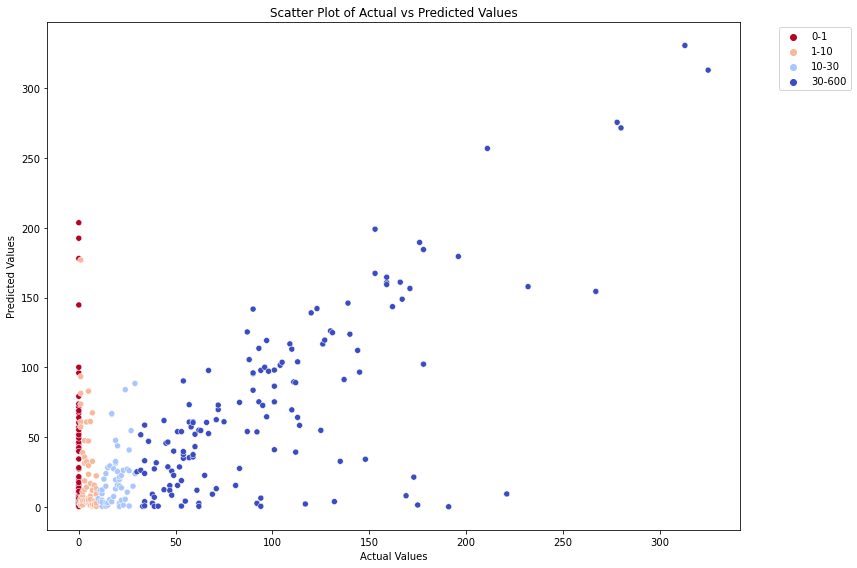

In [36]:
y_test2_sorted = y_test2.sort_values('obs_contact_y')
y_test2_new = y_test2_sorted.reset_index(drop=True)

ranges = [(0, 1), (1, 10), (10,30) ,(30, 600)]

# Generate a colormap index for each observation in y_test2_new['obs_contact_y']
obs_contact_colors = np.zeros_like(y_test2_new['obs_contact_y'], dtype=int)
for i, (start, end) in enumerate(ranges):
    obs_contact_colors[(start <= y_test2_new['obs_contact_y']) & (y_test2_new['obs_contact_y'] < end)] = i

# Create a dictionary to map colormap indices to value ranges
legend_labels = {i: f'{start}-{end}' for i, (start, end) in enumerate(ranges)}

# Plot the scatterplot with custom colors
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test2_new['obs_contact_y'], y=y_test2_new['predictions'], hue=obs_contact_colors, palette='coolwarm_r')

# Customize the legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = [legend_labels[int(label)] for label in _]

# Move the legend outside the plot
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.tight_layout()  # Ensures the legend is not cut off
plt.show()

# 6.  Unsupervised Clustering and Elbow Method for Grouping Protein Pairs Based on Interface Residues

>*From this point onward, our focus will be solely on the Human 20s Proteasome.*

In [37]:
df = pd.read_csv('residues.txt').drop(['numbers'],axis=1)
convert_dic={'A':'A1', 'B':'A2', 'C':'A3', 'D':'A4', 'E':'A5', 'F':'A6', 'G':'A7', 'H':'H1', 'I':'H2', 'J':'H3', 'K':'H4', 'L':'H5', 'a':'H6', 'b':'H7'}
convert_dic2 = {v: k for k, v in convert_dic.items()}
df['res1'] = df['res1'].apply(ast.literal_eval)
df['res2'] = df['res2'].apply(ast.literal_eval)
df['pair'] = df['chain1']+'_'+df['chain2']
df

,id,chain1,chain2,res1,res2,pair
0,1BZ0,A,A,"[27, 30, 31, 34, 35, 36, 50, 103, 104, 106, 10...","[27, 30, 31, 34, 35, 36, 50, 103, 104, 106, 10...",A_A
1,1BZ0,A,B,"[27, 30, 31, 34, 35, 36, 50, 103, 104, 106, 10...","[26, 30, 33, 34, 35, 37, 51, 55, 108, 109, 111...",A_B
2,1BZ0,B,B,"[26, 30, 33, 34, 35, 36, 51, 55, 105, 108, 109...","[26, 30, 33, 34, 35, 36, 51, 55, 105, 108, 109...",B_B
3,1CAX,A,A,"[4, 6, 7, 8, 9, 10, 11, 13, 25, 27, 30, 36, 37...","[4, 6, 7, 8, 9, 10, 11, 13, 25, 27, 30, 36, 37...",A_A
4,1CAX,A,B,"[14, 16, 17, 26, 29, 55, 57, 58, 60, 62, 64, 7...","[53, 55, 56, 58, 60, 61, 63, 74, 76, 78, 80, 8...",A_B
...,...,...,...,...,...,...
1911,8C5C,b,A,"[2, 45, 46, 128, 129, 161, 162, 163, 197, 245,...","[11, 71, 72, 73, 74, 77, 96, 97, 98, 100, 101,...",b_A
1912,8C5C,b,b,"[11, 69, 70, 94, 95, 99, 103, 173, 174, 176, 1...","[2, 128, 129, 162, 163, 197, 245, 246, 247, 24...",b_b
1913,8CZO,a,a,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 74, 75, 76, 78...","[1, 2, 3, 4, 5, 6, 8, 9, 12, 74, 75, 76, 78, 7...",a_a
1914,8CZO,a,E,"[18, 19, 22, 26, 27, 43, 44, 47, 48, 50, 51, 5...","[1, 4, 8, 70, 71, 74, 78, 84, 87, 88, 89, 90, ...",a_E


### Quality of clustering

The clustermaps presented below yield satisfying results as they effectively differentiate the relationships between chains. chains A1 to A7 and H1 to H7 make two rings which are stacked on top of each other.
1. Each chain with its previous one: A1 with A7, A2 with A1, A3 with A2, A4 with A3 and ... also, H1 with H7, H2 with H1 and ... 
2. Each chain with the next one: A1 with A2, A2 with A3 and ... also, H1 with H2, H2 with H3 and ...
3. Each chain from first ring (A) with chain in second ring (H): A1 with H2, A4 with H5 and ... 

By providing a multiple sequence alignment, we ensure that the residue numbers in all protein chains are aligned and correspond to each other accurately.

Only interacting pairs are included 
Pairs that are masked are the ones that are not predicted correctly


O:\anaconda3\anaconda3\lib\site-packages\seaborn\matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


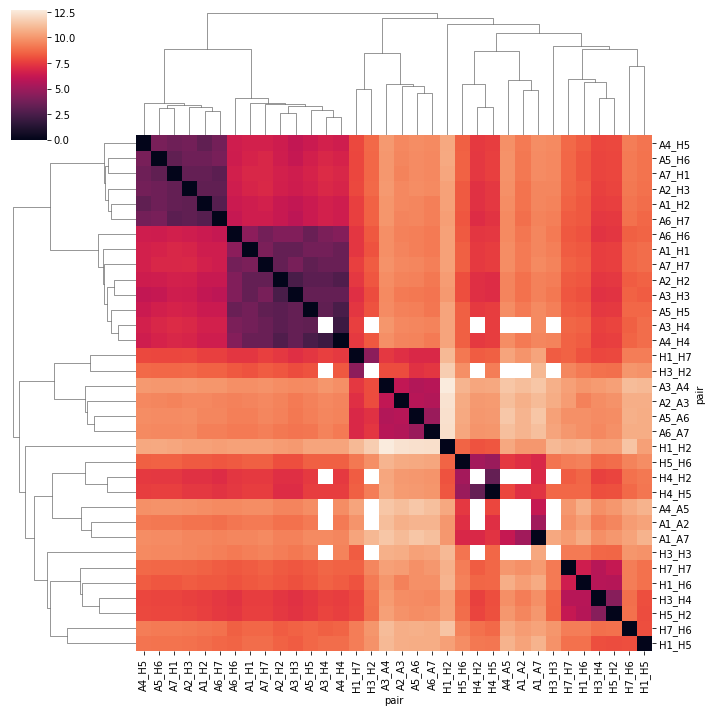

In [38]:
msa='''>A
MAE-R--GYSFSLTTFSPSGKLVQIEYALAAVAGG-APSVGIKAANGVVLATEKKQKS-ILYDERSVHKVEPITKHIGLVYSGMGPDYRVLVHRARKLAQQYY-LVYQEPIPTAQLVQRVASVMQEYT-----QSGGVRPFGVSLLICGWNE--GRPYLFQSDPSGAYFAWK-ATAMGKNYVNGKTFLEKRYN---------E--DLELEDAIHTAILTLKESFEG--Q-MTEDNIEVGICNEA----GFRRLT------PTEVKDYLAAI----A------------------------------------
>J
----------------------------------M-EYLIGIQGPDYVLVASDRVAASNIVQMKDDHDKMFKMSEKILLLCVGEAGDTVQFAEYIQKNVQLYK-MRNGYELSPTAAANFTRRNLADCL-------RSRTPYHVNLLLAGYDEH-EGPALYYMDYLAALAKAP-FAAHGYGAFLTLSILDRYYT---------P--TISRERAVELLRKCLEELQKRF-I-LNLPTFSVRIIDKN----GIHDLD------NISFPK--Q--------------------------GS---------------
>K
------------------------------------TTTLAFKFRHGVIVAADSRATAGAYIASQTVKKVIEINPYLLGTMAGGAADCSFWERLLARQCRIYE-LRNKERISVAAASKLLANMVYQYK---------GMGLSMGTMICGWDKR--GPGLYYVDSEGNRISGA-TFSVGSGSVYAYGVMDRGYS---------Y--DLEVEQAYDLARRAIYQATYRD-A-YSGGAVNLYHVRED----GWIR---VS---SDNVADLHEKYSG-STP-----------------------------------
>L
--------------RFS------------PYVFNG-GTILAIAGEDFAIVASDTRLSEGFSIHTRDSPKCYKLTDKTVIGCSGFHGDCLTLTKIIEARLKMYK-HSNNKAMTTGAIAAMLSTILYSRR---------FFPYYVYNIIGGLDEE-GKGAVYSFDPVGSYQRD-SFKAGGSASAMLQPLLDNQVGFKNMQNVEHV--PLSLDRAMRLVKDVFISAAERD-V-YTGDALRICIVTKE----GIREET-VSLRK--------------------------------------------------D-
>a
--------------TQ-------------NPMVTG-TSVLGVKFEGGVVIAADMLGSYGSLARFRNISRIMRVNNSTMLGASGDYADFQYLKQVLGQMVIDEELLGDGHSYSPRAIHSWLTRAMYSRR-------SKMNPLWNTMVIGGYADG--ESFLGYVDMLGVAYEAP-SLATGYGAYLAQPLLREVLEKQ-------P--VLSQTEARDLVERCMRVLYYRD-A-RSYNRFQIATVTEK----GVEIEGPLSTETNWDIAHMISGF----E------------------------------------
>b
------------------------------------TTIMAVQFDGGVVLGADSRTTTGSYIANRVTDKLTPIHDRIFCCRSGSAADTQAVADAVTYQLGFHS-IELNEPPLVHTAASLFKEMCYRYR----------EDLMAGIIIAGWDPQ-EGGQVYSVPMGGMMVRQS-FAIGGSGSSYIYGYVDATYR---------E--GMTKEECLQFTANALALAMERD-G-SSGGVIRLAAIAES----GVERQV-LL---GDQIPKFAVATLPPA-------------------------------------
>B
MSR----RYDSRTTIFSPEGRLYQVEYAMEAIGHA-GTCLGILANDGVLLAAERRNIHKLLDEVFFSEKIYKLNEDMACSVAGITSDANVLTNELRLIAQRYL-LQYQEPIPCEQLVTALCDIKQAYT-----QFGGKRPFGVSLLYIGWDKH-YGFQLYQSDPSGNYGGWK-ATCIGNNSAAAVSMLKQDYK---------EG-EMTLKSALALAIKVLNKTMDV--SKLSAEKVEIATLTRENGKTVIRVLK------QKEVEQLIKKH----EEEEAKAEREKKEKEQKEKDK----------------
>C
M------SYDRAITVFSPDGHLFQVEYAQEAVKKG-STAVGVRGRDIVVLGVEKKSVA-KLQDERTVRKICALDDNVCMAFAGLTADARIVINRARVECQSHR-LTVEDPVTVEYITRYIASLKQRYT-----QSNGRRPFGISALIVGFDFD-GTPRLYQTDPSGTYHAWK-ANAIGRGAKSVREFLEKNYT---------DEAIETDDLTIKLVIKALLEVVQ-----SGGKNIELAVMRRDQ---SLKILN------PEEIEKYVAEI----EKEK--EENEKKKQK--K-AS----------------
>D
MFL-TRSEYDRGVNTFSPEGRLFQVEYAIEAIKLG-STAIGIQTSEGVCLAVEKRITS-PLMEPSSIEKIVEIDAHIGCAMSGLIADAKTLIDKARVETQNHW-FTYNETMTVESVTQAVSNLALQFGEEDADPGAMSRPFGVALLFGGVDE--KGPQLFHMDPSGTFVQCD-ARAIGSASEGAQSSLQEVYH---------K--SMTLKEAIKSSLIILKQVMEE--K-LNATNIELATVQPG---QNFHMFT------KEELEEVIKD-------------------------I----------------
>E
MFR---NQYDNDVTVWSPQGRIHQIEYAMEAVKQG-SATVGLKSKTHAVLVALKRAQS-ELA--AHQKKILHVDNHIGISIAGLTADARLLCNFMRQECLDSR-FVFDRPLPVSRLVSLIGSKTQIPT-----QRYGRRPYGVGLLIAGYDDM--GPHIFQTCPSANYFDCR-AMSIGARSQSARTYLERHMS---------EFMECNLNELVKHGLRALRETLPAEQD-LTTKNVSIGIVGKDL---EFTIYD------DDDVSPFLEGL----EER-------PQRKA--Q-PAQPADEPAEKADEPMEH
>F
MSS-IGTGYDLSASTFSPDGRVFQVEYAMKAVENS-STAIGIRCKDGVVFGVEKLVLS-KLYEEGSNKRLFNVDRHVGMAVAGLLADARSLADIAREEASNFR-SNFGYNIPLKHLADRVAMYVHAYT-----LYSAVRPFGCSFMLGSYSVN-DGAQLYMIDPSGVSYGYW-GCAIGKARQAAKTEIEKLQM---------K--EMTCRDIVKEVAKIIYIVHDEV-K-DKAFELELSWVGELTN-GRHEIVP------KDIREEAEKYA----KESL---K-EEDESD--D-D-----------NM----
>G
MSRGSSAGFDRHITIFSPEGRLYQVEYAFKAINQGGLTSVAVRGKDCAVIVTQKKVPD-KLLDSSTVTHLFKITENIGCVMTGMTADSRSQVQRARYEAANWK-YKYGYEIPVDMLCKRIADISQVYT-----QNAEMRPLGCCMILIGIDEE-QGPQVYKCDPAGYYCGFK-ATAAGVKQTESTSFLEKKVK---------KKFDWTFEQTVETAITCLSTVLS-I-D-FKPSEIEVGVVTVEN--PKFRILT------EAEIDAHLVAL----AER-----------------------------D----
>H
------------------------------------TTIAGVVYKDGIVLGADTRATEGMVVADKNCSKIHFISPNIYCCGAGTAADTDMTTQLISSNLELHS-LSTGRLPRVVTANRMLKQMLFRYQ----------GYIGAALVLGGVDVT--GPHLYSIYPHGSTDKLP-YVTMGSGSLAAMAVFEDKFR---------P--DMEEEEAKNLVSEAIAAGIFND-L-GSGSNIDLCVISKN----KLDFLR------PYTVPNKKGTR----LGRYRCEKGTTAVLTEKITPLEIEVLEETVQTMDTS-
>I
--------------M-S------------IMSYNG-GAVMAMKGKNCVAIAADRRFGIQAQMVTTDFQKIFPMGDRLYIGLAGLATDVQTVAQRLKFRLNLYE-LKEGRQIKPYTLMSMVANLLYEKR---------FGPYYTEPVIAGLDPKTFKPFICSLDLIGCPMVTDDFVVSGTCAEQMYGMCESLWE---------P--NMDPDHLFETISQAMLNAVDRD-A-VSGMGVIVHIIEKD----KITTRT-LKARM--------------------------------------------------D-'''
msa=msa.split('>')[1:]
msa=list(map(lambda x:x.split('\n')[:2],msa))
msa={a[0]:a[1] for a in msa}

def map_res(lst,chain):
    seq=msa[chain]
    new_lst=[]
    for i in lst:
        counter=0
        for ii,res in enumerate(seq):
            if res != '-':
                counter += 1
                if counter==int(i):
                    new_lst.append(ii+1)
    return new_lst

#print ('I wanted to see wether those that are nor correctly predicted by AlphaFold are having similar interface or not')

proteosome = df[df['id']=='5LE5']
proteosome = proteosome[['pair','res1','res2']].set_index('pair')

# Remove those that do not have a contact in pdb because there's no need the cluster them (obs_contact >6)
index_list=['A_B', 'A_G', 'A_H', 'A_I', 'B_C', 'B_I', 'B_J', 'C_D', 'C_J', 'C_K', 'D_E', 'D_K', 'D_L', 'E_L', 'E_a', 'F_a', 'F_b', 'G_b', 'H_I', 'H_b', 'H_L', 'H_a', 'J_I', 'K_I', 'L_I', 'J_J', 'J_K', 'K_L', 'L_a', 'b_a', 'b_b', 'E_F', 'F_G', 'G_H']
proteosome = proteosome[proteosome.index.isin(index_list)]

for _, row in proteosome.iterrows():
    chain1=_[0]
    chain2=_[2]
    proteosome.loc[_,'res1'] = map_res(row['res1'],chain1)
    proteosome.loc[_,'res2'] = map_res(row['res2'],chain2)


all_residues = set()
for _, row in proteosome.iterrows():
    all_residues.update(row['res1'])
    all_residues.update(row['res2'])
all_residues=list(all_residues)
M=np.zeros((len(proteosome),2,len(all_residues)))

D1=0
for _, row in proteosome.iterrows():
    for res in row['res1']:
        D3 = all_residues.index(res)
        M[D1,0,D3]+=1
    for res in row['res2']:
        D3 = all_residues.index(res)
        M[D1,1,D3]+=1
    D1+=1

# reshape the Matrix to 2D and Make a DataFrame from it
from scipy.spatial.distance import pdist, squareform
M_2d = squareform(pdist(M.reshape(len(M), len(M[0][0])*2), metric='euclidean'))
M_2d=pd.DataFrame(M_2d, index=proteosome.index, columns=proteosome.index)

# Mask those that are not predicted correctly by AlphaFold
print ('Only interacting pairs are included \nPairs that are masked are the ones that are not predicted correctly')
FNs = ['A_B', 'C_K', 'D_E', 'J_I', 'K_I', 'J_J']
#print ('\t'.join(FNs))
FN_indices = [proteosome.index.get_loc(fn) for fn in FNs]
mask = np.zeros_like(M_2d)
mask[np.ix_(FN_indices, FN_indices)] = True

convert_dic={'A':'A1', 'B':'A2', 'C':'A3', 'D':'A4', 'E':'A5', 'F':'A6', 'G':'A7', 'H':'H1', 'I':'H2', 'J':'H3', 'K':'H4', 'L':'H5', 'a':'H6', 'b':'H7'}
for column_name in M_2d.columns:
    new_column_name = convert_dic[column_name[0]]+'_'+convert_dic[column_name[2]]
    M_2d.rename(columns={column_name: new_column_name}, inplace=True)
for index_name in M_2d.index:
    new_index_name = convert_dic[index_name[0]]+'_'+convert_dic[index_name[2]]
    M_2d.rename(index={index_name: new_index_name}, inplace=True)

# Create the cluster map with the mask
sns.clustermap(M_2d, figsize=(10, 10), mask=mask)
plt.show()

**Every Possible binding Mode**

O:\anaconda3\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


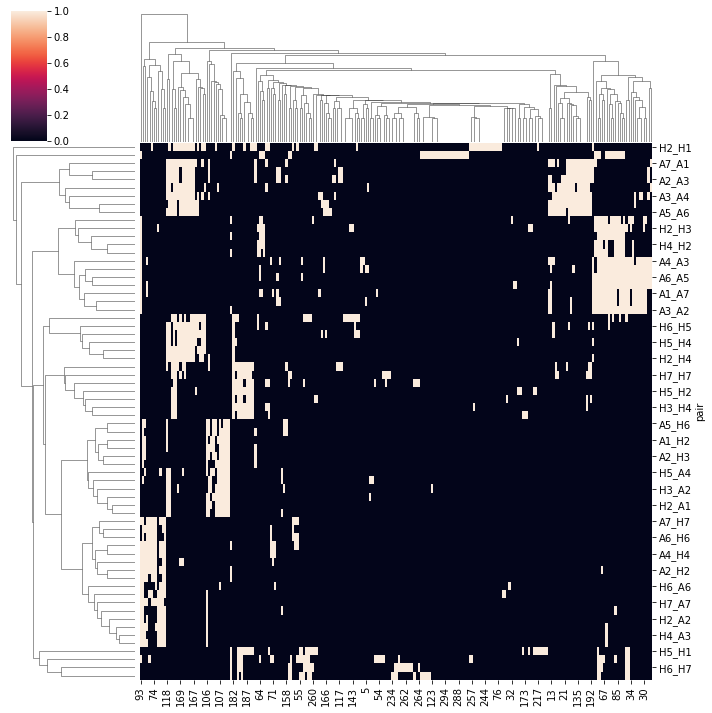

In [39]:
proteosome = df[df['id']=='5LE5']
proteosome = proteosome[['pair','res1','res2']].set_index('pair')

# Remove those that do not have a contact in pdb because there's no need the cluster them (obs_contact >6)
index_list=['A_B', 'A_G', 'A_H', 'A_I', 'B_C', 'B_I', 'B_J', 'C_D', 'C_J', 'C_K', 'D_E', 'D_K', 'D_L', 'E_L', 'E_a', 'F_a', 'F_b', 'G_b', 'H_I', 'H_b', 'H_L', 'H_a', 'J_I', 'K_I', 'L_I', 'J_J', 'J_K', 'K_L', 'L_a', 'b_a', 'b_b', 'E_F', 'F_G', 'G_H']
proteosome = proteosome[proteosome.index.isin(index_list)]

proteosome2={'pair':[], 'res':[]}
for _,row in proteosome.iterrows():
    proteosome2['pair'].append(_[0]+'_'+_[2])
    proteosome2['res'].append(row['res1'])
    if _[0] == _[2]: continue
    proteosome2['pair'].append(_[2]+'_'+_[0])
    proteosome2['res'].append(row['res2'])
proteosome2 = pd.DataFrame.from_dict(proteosome2)

for _, row in proteosome2.iterrows():
    chain=row['pair'][0]
    proteosome2.loc[_,'res'] = map_res(row['res'],chain)


all_residues = set()
for _, row in proteosome2.iterrows():
    all_residues.update(row['res'])
all_residues=list(all_residues)
    
M=np.zeros((len(all_residues),len(proteosome2)))
D1=0
for _, row in proteosome2.iterrows():
    for res in row['res']:
        D2 = all_residues.index(res)
        M[D2,D1]+=1
    D1+=1
M=pd.DataFrame(M, columns=proteosome2['pair'], index= all_residues)
for column_name in M.columns:
    new_column_name = convert_dic[column_name[0]]+'_'+convert_dic[column_name[2]]
    M.rename(columns={column_name: new_column_name}, inplace=True)
#M = M.T[M.T.index.str.startswith('H')]
sns.clustermap(M.T, figsize=(10, 10))

**Let's focus more on Human 20s Proteosome (5LE5) --> 5 predictions per each pair**

To mitigate the inclusion of incorrectly predicted pairs, we expanded our analysis by considering the top-5 ranked predictions for the Human 20s Proteasome. By incorporating a broader set of predictions, we aimed to enhance the accuracy and reliability of our results.

In [107]:
df = pd.read_csv('5LE5_residues_dataframe.txt')
convert_dic={'A':'A1', 'B':'A2', 'C':'A3', 'D':'A4', 'E':'A5', 'F':'A6', 'G':'A7', 'H':'H1', 'I':'H2', 'J':'H3', 'K':'H4', 'L':'H5', 'a':'H6', 'b':'H7'}
df['res1'] = df['res1'].apply(ast.literal_eval)
df['res2'] = df['res2'].apply(ast.literal_eval)
df['pair'] = df['chain1']+'_'+df['chain2']+'_'+df['rank'].astype(str)
df

,chain1,chain2,rank,res1,res2,pair
0,a,a,0,"[2, 3, 4, 5, 7, 9, 29, 30, 32, 35, 100, 103, 1...","[2, 3, 4, 5, 7, 9, 29, 30, 32, 35, 100, 103, 1...",a_a_0
1,A,a,0,"[9, 11, 13, 18, 19, 20, 21, 22, 23, 25, 26, 29...","[1, 2, 3, 4, 5, 6, 30, 32, 33, 35, 36, 39, 56,...",A_a_0
2,A,A,0,"[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 2, 3, 4, 6, 7, 8, 10, 11, 20, 21, 23, 24, ...",A_A_0
3,a,a,1,"[3, 4, 7, 9, 10, 32, 33, 34, 100, 107, 109, 12...","[3, 4, 7, 9, 10, 32, 33, 100, 107, 109, 126, 1...",a_a_1
4,A,a,1,"[7, 9, 11, 12, 13, 18, 19, 20, 21, 22, 23, 26,...","[1, 2, 3, 4, 5, 6, 30, 32, 35, 36, 39, 56, 57,...",A_a_1
...,...,...,...,...,...,...
520,L,L,0,"[1, 3, 4, 5, 6, 7, 30, 33, 34, 35, 97, 100, 10...","[1, 3, 4, 5, 6, 7, 30, 33, 34, 35, 97, 100, 10...",L_L_0
521,L,L,1,"[1, 2, 3, 4, 5, 7, 33, 93, 97, 100, 101, 102, ...","[1, 2, 3, 4, 5, 7, 33, 93, 97, 100, 101, 102, ...",L_L_1
522,L,L,2,"[1, 2, 3, 4, 5, 6, 7, 33, 93, 101, 102, 103, 1...","[1, 2, 3, 4, 5, 6, 7, 33, 93, 101, 102, 103, 1...",L_L_2
523,L,L,3,"[1, 2, 3, 4, 5, 7, 30, 33, 34, 100, 101, 102, ...","[1, 2, 3, 4, 5, 7, 30, 33, 34, 100, 101, 102, ...",L_L_3


## Clustering Analysis of the Top 5 Predictions for All Pairs in Each Protein Chain

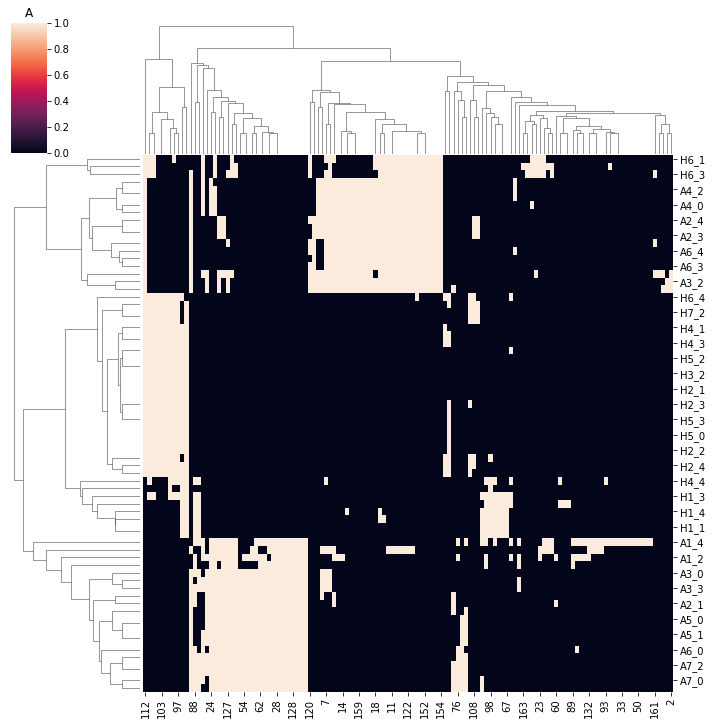

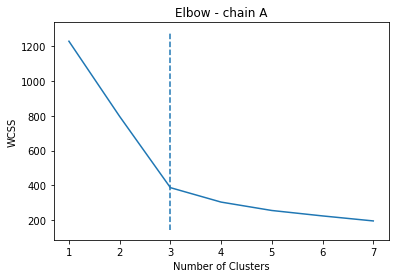

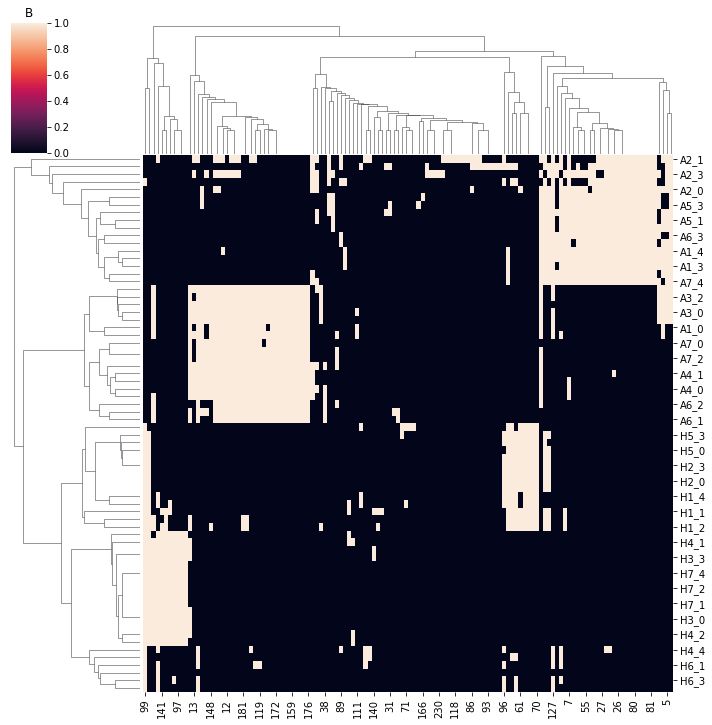

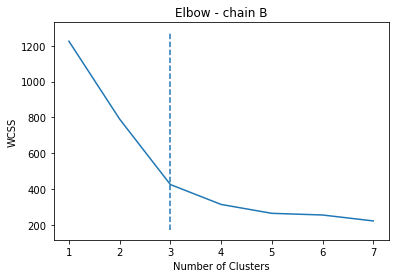

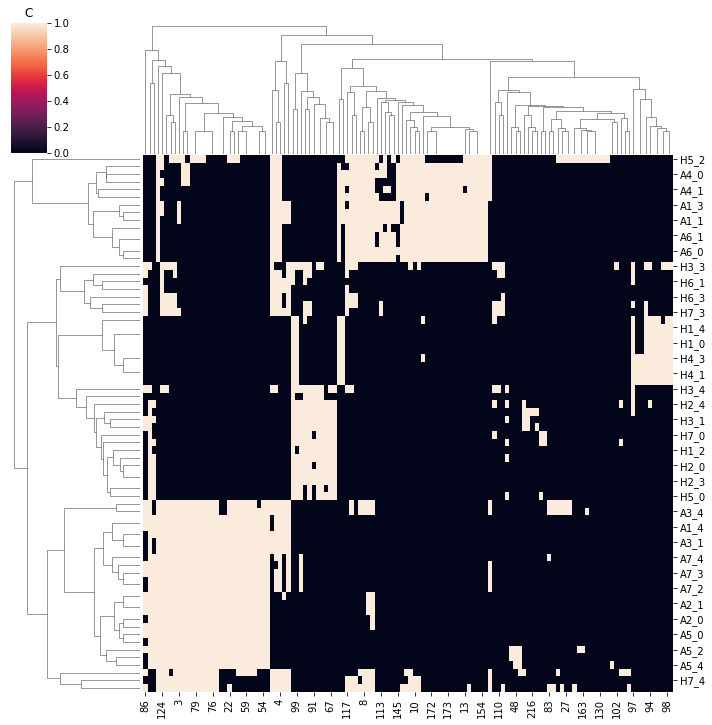

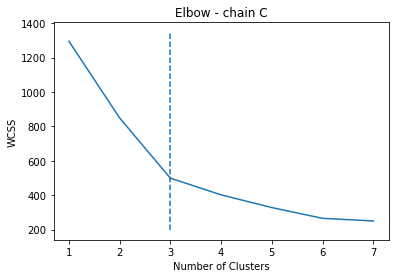

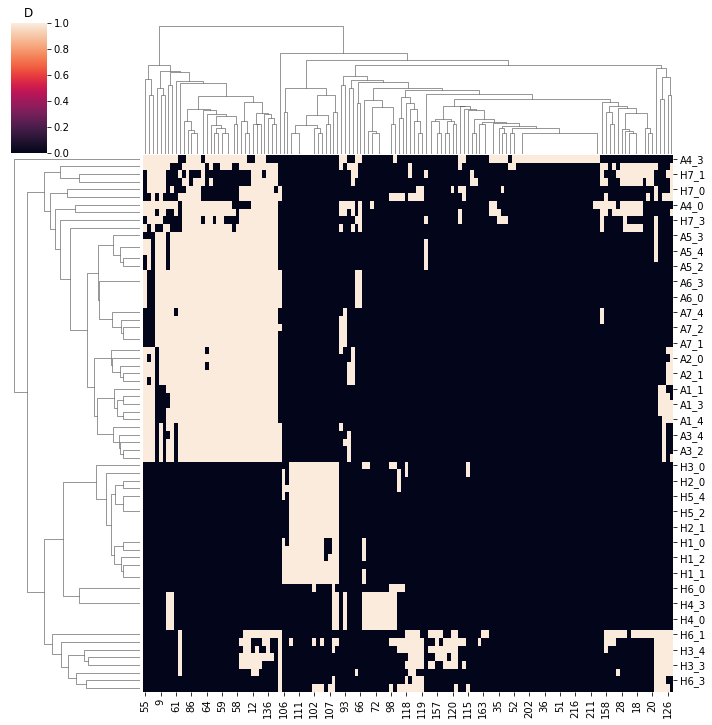

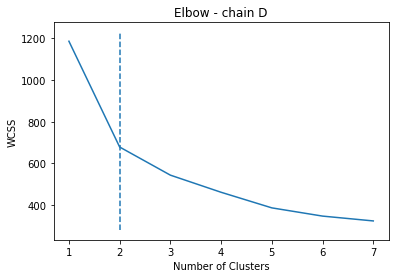

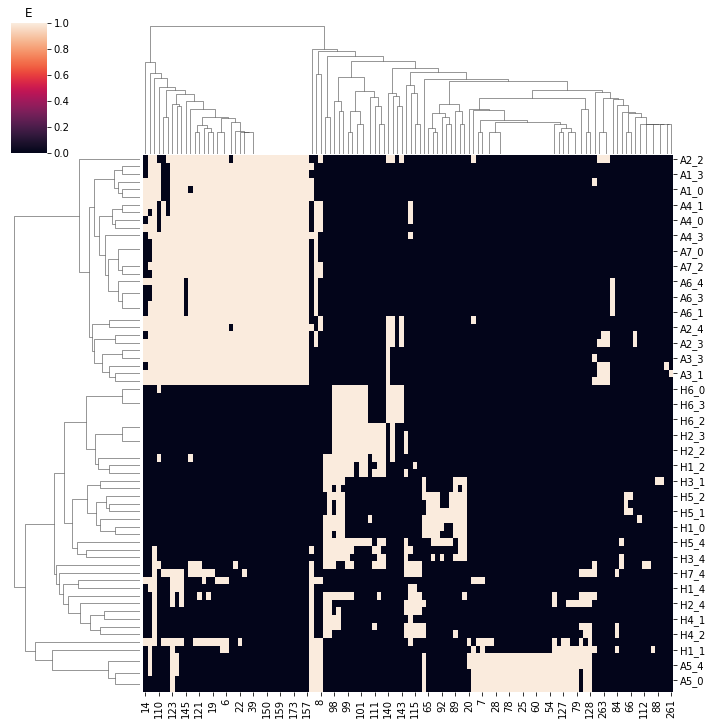

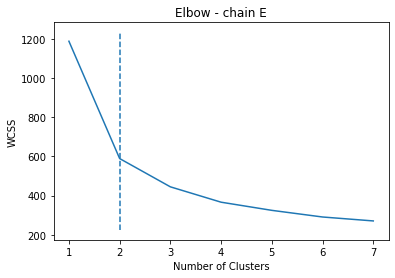

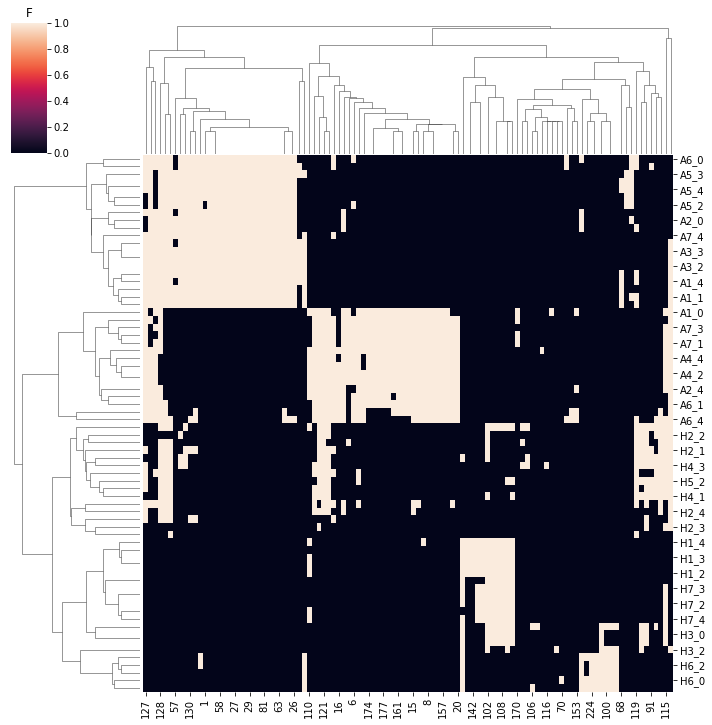

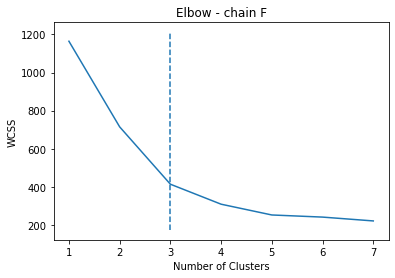

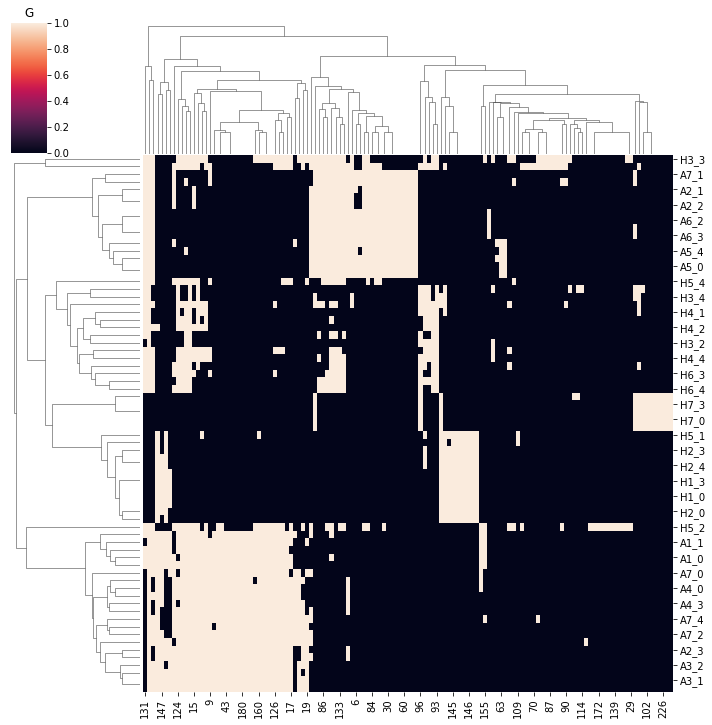

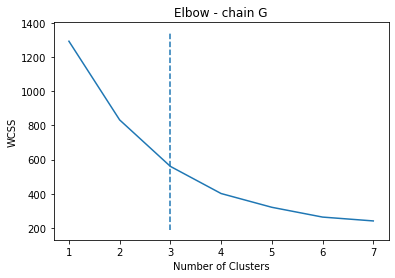

O:\anaconda3\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


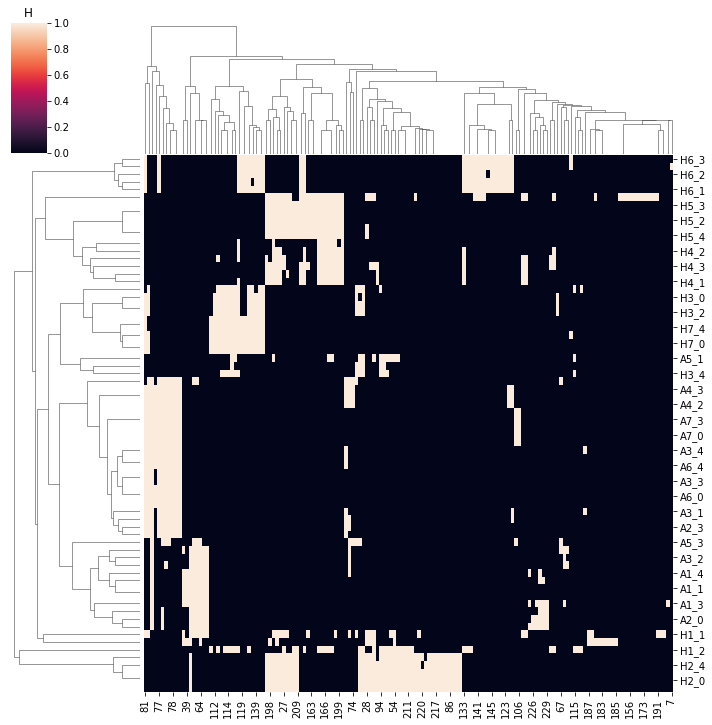

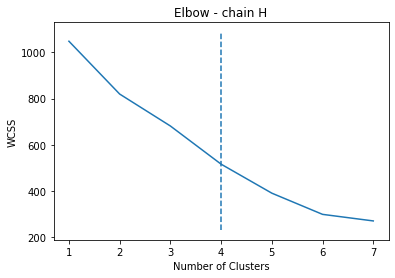

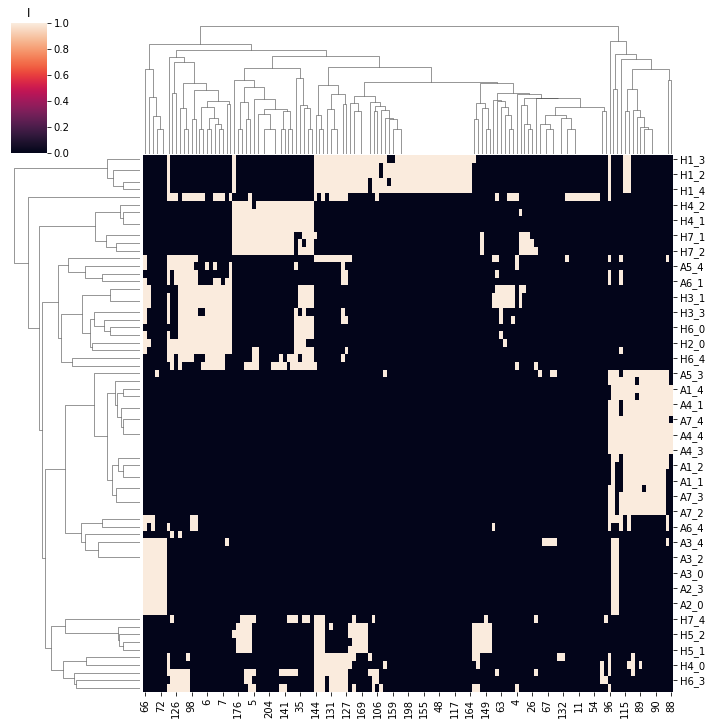

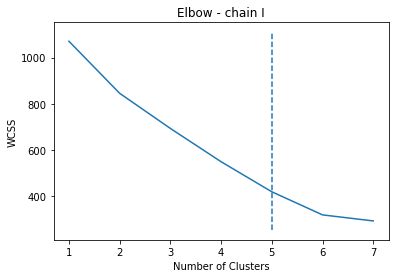

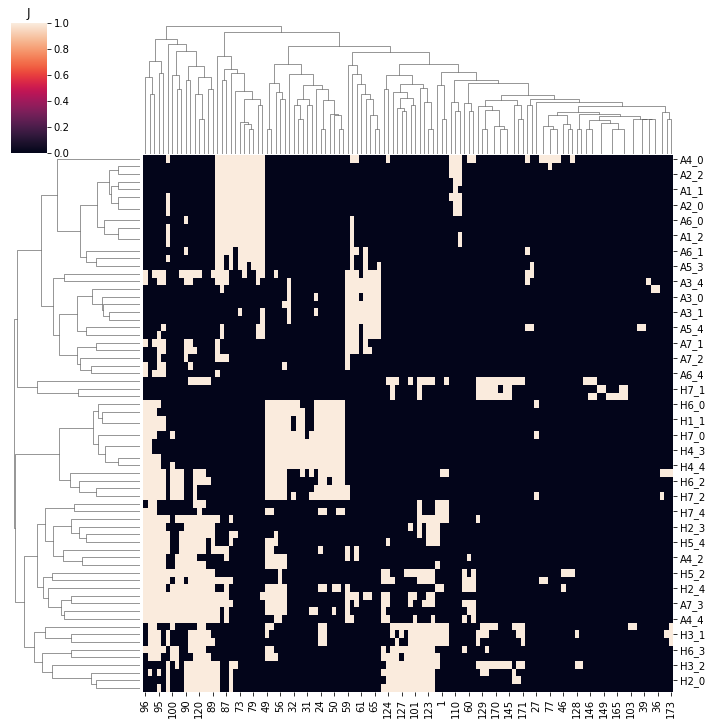

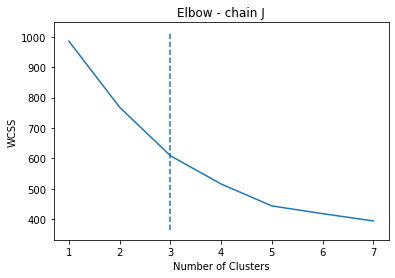

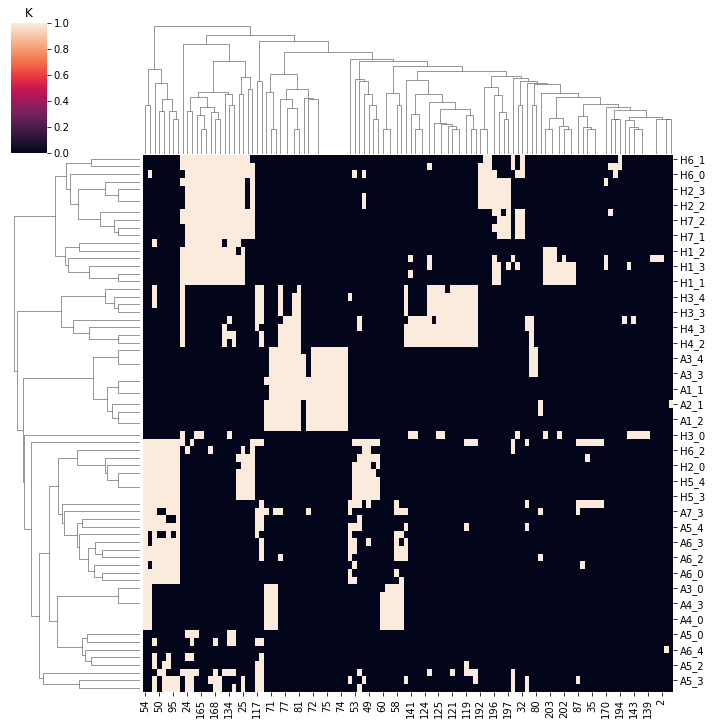

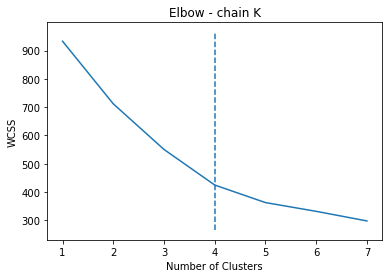

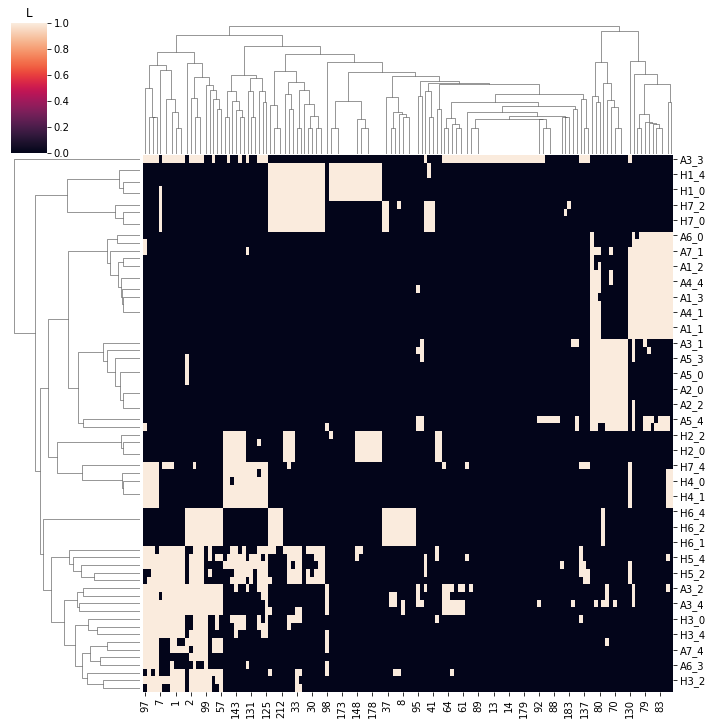

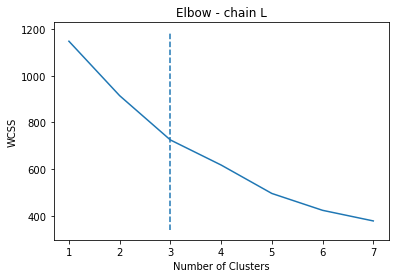

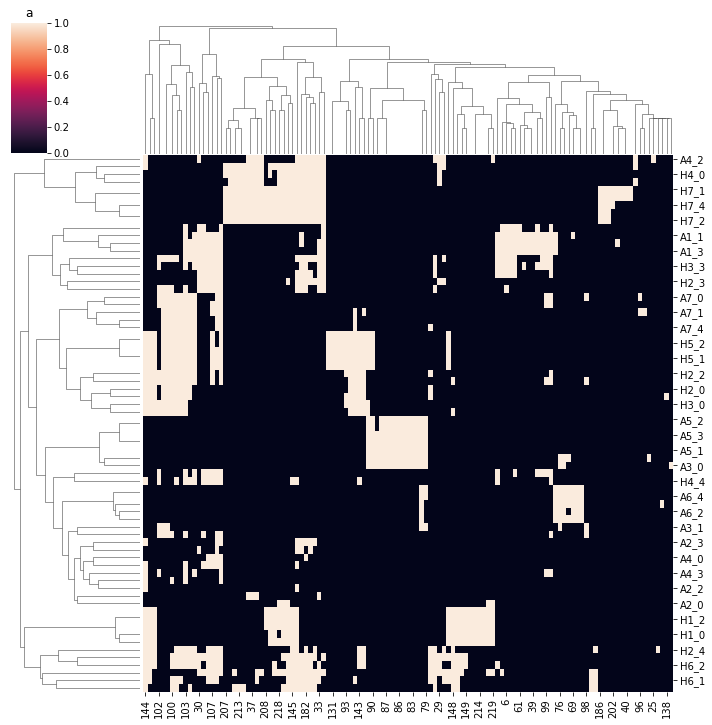

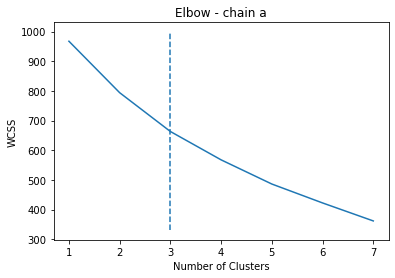

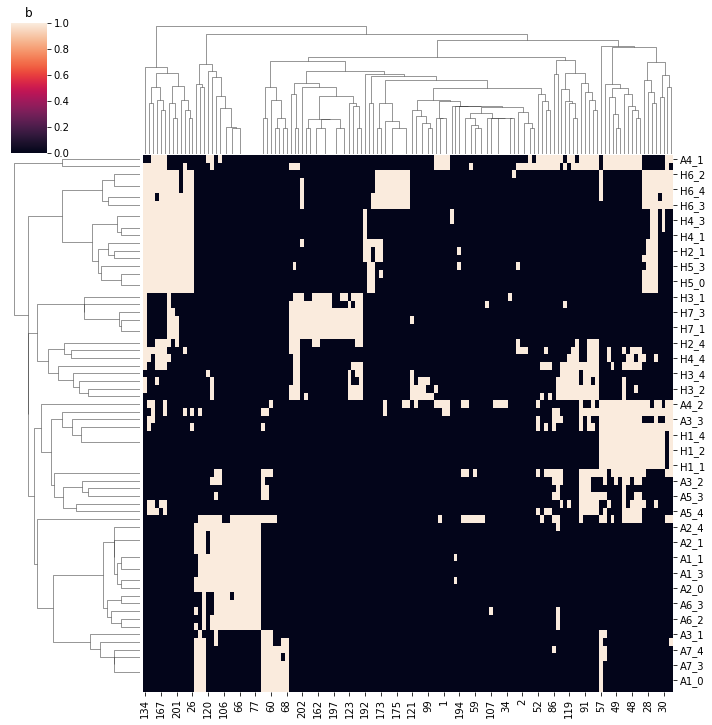

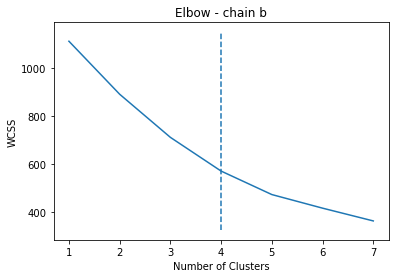

In [112]:
opt_clusters={}

for chain in 'ABCDEFGHIJKLab':
    df_chain=df[df['pair'].str.contains(chain)]

    # residue vector
    residues = []
    for i, row in df_chain.iterrows():
        if row['chain1']==chain:
            residues.extend(row['res1'])
        elif row['chain2']==chain:
            residues.extend(row['res2'])
    residues = list(set(residues))

    # make dataframe
    columns=[]
    M=np.zeros((len(residues),len(df_chain['chain2'])))
    cn=0
    for i,row in df_chain.iterrows():
        if row['chain1']==chain:
            columns.append(convert_dic[row['pair'][2]]+'_'+row['pair'][4])
            for res in row['res1']:
                rn = residues.index(res)
                M[rn,cn]+=1
            cn+=1
        elif row['chain2']==chain:
            columns.append(convert_dic[row['pair'][0]]+'_'+row['pair'][4])
            for res in row['res2']:
                rn = residues.index(res)
                M[rn,cn]+=1
            cn+=1
    M=pd.DataFrame(M, index=residues, columns= columns)
    sns.clustermap(M.T,figsize=(10, 10))
    plt.title(chain)
    plt.show()

    wcss = []
    for i in range(1, 8):
        kmeans = KMeans(n_clusters=i, init='random', random_state=56,n_init='auto') #k-means++ #best one --> random,random_state:25, range:8, n_init='auto
        kmeans.fit(M.T.to_numpy())
        wcss.append(kmeans.inertia_)
    # Find the knee point using the KneeLocator module
    kl = KneeLocator(range(1, 8), wcss, curve='convex', direction='decreasing')
    knee = kl.elbow
    opt_clusters[chain]=kl.elbow

    plt.plot(range(1, 8), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow - chain %s' %chain)
    plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.show()

In [113]:
for i in opt_clusters:
    print ('The Optimal Number of Clusters for Chain %s: %d'%(convert_dic[i], opt_clusters[i]))

The Optimal Number of Clusters for Chain A1: 3
The Optimal Number of Clusters for Chain A2: 3
The Optimal Number of Clusters for Chain A3: 3
The Optimal Number of Clusters for Chain A4: 2
The Optimal Number of Clusters for Chain A5: 2
The Optimal Number of Clusters for Chain A6: 3
The Optimal Number of Clusters for Chain A7: 3
The Optimal Number of Clusters for Chain H1: 4
The Optimal Number of Clusters for Chain H2: 5
The Optimal Number of Clusters for Chain H3: 3
The Optimal Number of Clusters for Chain H4: 4
The Optimal Number of Clusters for Chain H5: 3
The Optimal Number of Clusters for Chain H6: 3
The Optimal Number of Clusters for Chain H7: 4


**K-means Clustering of Pairs into Optimal Number of Groups**

In [114]:
groups_dic={}
for chain in 'ABCDEFGHIJKLab':
    df_chain=df[df['pair'].str.contains(chain)]

    # residue vector
    residues = []
    for i, row in df_chain.iterrows():
        if row['chain1']==chain:
            residues.extend(row['res1'])
        elif row['chain2']==chain:
            residues.extend(row['res2'])
    residues = list(set(residues))

    # make dataframe
    columns=[]
    M=np.zeros((len(residues),len(df_chain['chain2'])))
    cn=0
    for i,row in df_chain.iterrows():
        if row['chain1']==chain:
            columns.append(convert_dic[row['pair'][2]]+'_'+row['pair'][4])
            for res in row['res1']:
                rn = residues.index(res)
                M[rn,cn]+=1
            cn+=1
        elif row['chain2']==chain:
            columns.append(convert_dic[row['pair'][0]]+'_'+row['pair'][4])
            for res in row['res2']:
                rn = residues.index(res)
                M[rn,cn]+=1
            cn+=1
    M=pd.DataFrame(M, index=residues, columns= columns).T

    groups_dic[chain]=[[] for i in range(opt_clusters[chain])]
    # Create the KMeans object with 3 clusters
    kmeans = KMeans(n_clusters=opt_clusters[chain],n_init='auto')

    # Fit the model to the dataset
    kmeans.fit(M)

    # Get the cluster labels for each data point
    labels = kmeans.labels_

    # Print the cluster labels for each row
    for i, label in enumerate(labels):
        #print(f"row {i+1}: Cluster {label+1}")
        #labels_dic[M.index[i]]=label+1
        groups_dic[chain][int(label)].append(M.index[i])

In [115]:
df = pd.read_csv('5LE5_final_scores.txt')
df

,pdockq1,pdockq2,pred_contact,pdb_id,IntraclashesGroup1,IntraclashesGroup2,Interaction Energy,Backbone Hbond,Sidechain Hbond,Van der Waals,...,electrostatic kon,partial covalent bonds,energy Ionisation,Entropy Complex,Number of Residues,Interface Residues,Interface Residues Clashing,Interface Residues VdW Clashing,Interface Residues BB Clashing,ptm_iptm
0,0.062,0.425,93.0,5LE5_C_5LE5_G_1,39.2286,52.2869,12.1338,-6.947480,-2.842450e+00,-28.86820,...,-0.948693,0,0.000000e+00,2.384,494,73,6,6,0,0.600648
1,0.037,0.481,100.0,5LE5_C_5LE5_G_2,46.7919,56.9890,27.6384,-6.100450,-4.676820e+00,-31.24160,...,-0.747125,0,0.000000e+00,2.384,494,72,17,16,2,0.579014
2,0.033,0.479,107.0,5LE5_C_5LE5_G_4,42.4267,61.3565,40.9717,-4.675380,-5.252430e+00,-30.49240,...,-0.652963,0,2.775560e-17,2.384,494,75,21,19,4,0.543999
3,0.060,0.463,102.0,5LE5_C_5LE5_G_0,41.5814,57.5138,25.9025,-4.516710,-5.863460e+00,-30.91210,...,-1.018800,0,2.775560e-17,2.384,494,72,15,14,1,0.656497
4,0.032,0.515,102.0,5LE5_C_5LE5_G_3,36.7768,44.9533,34.6214,-6.016520,-6.328470e+00,-32.24130,...,-0.686803,0,0.000000e+00,2.384,494,74,19,17,4,0.566358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.012,0.276,44.0,5LE5_E_5LE5_H_1,57.1755,59.9042,90.1172,-0.914999,-5.660800e-01,-15.28720,...,0.283013,0,4.392800e-02,2.384,497,36,15,15,1,0.201849
521,0.012,0.197,36.0,5LE5_E_5LE5_H_2,58.2809,63.9882,290.7810,-1.062420,-2.350580e+00,-11.07440,...,-0.307781,0,1.138260e-01,2.384,497,28,12,12,6,0.192974
522,0.012,0.155,38.0,5LE5_E_5LE5_H_3,64.8241,68.6250,239.1620,-2.112760,-6.391880e-01,-12.09160,...,0.124308,0,4.557400e-02,2.384,497,28,17,16,8,0.190531
523,0.016,0.264,39.0,5LE5_E_5LE5_H_0,54.3505,61.9694,160.7680,-1.655150,-9.965370e-01,-10.77760,...,0.200705,0,3.885980e-03,2.384,497,24,11,11,0,0.265094


In [116]:
selected_features = ['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'ptm_iptm',
       'pdockq2', 'pdockq1', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing', 'electrostatic kon',
       'Interface Residues BB Clashing', 'Interface Residues VdW Clashing'] #'Number of Residues'

def just_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]-df[feature]+0.5
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pdb_id']
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])

df2[selected_features]=df[selected_features]

for feature in selected_features:
    if feature in ['pred_contact','pdockq2', 'pdockq1','ptm_iptm']:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))
    #elif feature in ['obs_contact']:
     #   df2 = df2.groupby('pdb_id').apply(lambda x: just_minmaxscale(x, feature))
    else:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))

X_test = df2.drop(['pdb_id','chain1','chain2', 'pair'], axis=1)

predictions={}
y_pred = model.predict(X_test)
for i in range(len(df['pdb_id'])):
    predictions[df['pdb_id'][i]]=float(y_pred[i])
    
#predictions

17/17 [==============================] - 0s 1ms/step


In [117]:
convert_dic={'A':'A1', 'B':'A2', 'C':'A3', 'D':'A4', 'E':'A5', 'F':'A6', 'G':'A7', 'H':'H1', 'I':'H2', 'J':'H3', 'K':'H4', 'L':'H5', 'a':'H6', 'b':'H7'}
convert_dic2 = {v: k for k, v in convert_dic.items()}
interactions=[]
for chain in groups_dic:
    for cluster in groups_dic[chain]:
        chain1=convert_dic[chain]
        #print (chain1, cluster)
        scores=[]
        for each in cluster:
            chain2=each[:2]
            rank=each[-1]
            pair1,pair2 = '5LE5_%s_5LE5_%s_%s'%(convert_dic2[chain1],convert_dic2[chain2],rank), '5LE5_%s_5LE5_%s_%s'%(convert_dic2[chain2],convert_dic2[chain1],rank)
            if pair1 in predictions:
                scores.append(predictions[pair1])
            else:
                scores.append(predictions[pair2])
        assert len(scores)== len(cluster)
        chosen_one=cluster[scores.index(max(scores))]
        interactions.append('%s_%s'%(chain1,chosen_one))

TM-Score shows the quality of prediction (TM-Score less than 0.9 means wrong prediction)

In [118]:
df = pd.read_csv('TMscores.txt',names=['pair','obs_contact','tmscore'])
df['rank'] = df['pair'].apply(lambda x: x.split('_')[-1])
df['pair'] = df['pair'].apply(lambda x: x[:-2])
df = df[df['pair'].str.contains('5LE5')]

In [119]:
everything=[]
for ip in interactions:
    check=False
    chain1=convert_dic2[ip[:2]]
    chain2=convert_dic2[ip[3:5]]
    rank=ip[-1]
    for _,row in df.iterrows():
        if rank==row['rank']:
            if row['pair'][5]==chain1 and row['pair'][12]==chain2:
                #print (list(row))
                everything.append(list(row))
                check=True
            elif row['pair'][5]==chain2 and row['pair'][12]==chain1:
                #print (list(row))
                everything.append(list(row))
                check=True
    if check==False:
        #print (['5LE5_%s_5LE5_%s'%(chain1,chain2),0,None,ip[-1]])
        everything.append(['5LE5_%s_5LE5_%s'%(chain1,chain2),0,None,ip[-1]])  

tuple_list = [tuple(sublist) for sublist in everything]
unique_tuples = set(tuple_list)
everything = [list(tpl) for tpl in unique_tuples]
#for i in sorted(everything, key=lambda x:x[0]): print (i) 
FP_count = int(len(list(filter(lambda x: x[1]<10,everything))))
TP_count = int(len(everything) - FP_count)
FN_count = int(len(df[df['obs_contact']>9])/5 - TP_count)
TN_count = int(105 - TP_count - FN_count - FP_count)
print (int(len(df[df['obs_contact']>9])/5), 'actual interacting pairs')
print (len(everything),'interacting pairs are predicted')
print (FP_count,'= False Positives')
print (FN_count,'= False Negatives')
print (TP_count,'= True Positives')
print (TN_count ,'= True Negatives')
results = pd.DataFrame(sorted(everything, key=lambda x:x[0]), columns=['pair', 'observed number of contacts', 'tm-score', 'ranking'])
results['pair'] = results['pair'].str.replace('5LE5_', '')
results['pair'] = results['pair'].apply(lambda x: convert_dic.get(x.split('_')[0], x.split('_')[0])+'_'+convert_dic.get(x.split('_')[1], x.split('_')[1]))
results.set_index('pair', inplace=True)
results

34 actual interacting pairs
30 interacting pairs are predicted
4 = False Positives
8 = False Negatives
26 = True Positives
67 = True Negatives


,observed number of contacts,tm-score,ranking
pair,,,
A1_A2,101,0.971,2
A1_A4,0,NaN,1
A1_A7,98,0.974,1
A1_H1,16,0.971,0
A1_H2,18,0.984,1
A2_A3,97,0.967,1
A2_H3,20,0.961,0
A3_A4,112,0.972,0
A3_H4,17,0.936,1


In [120]:
# Calculate scores
accuracy = (TP_count + TN_count) / (TP_count + TN_count + FP_count + FN_count)
precision = TP_count / (TP_count + FP_count)
recall = TP_count / (TP_count + FN_count)
f1 = 2 * precision * recall / (precision + recall)
mcc = (TP_count * TN_count - FP_count * FN_count) / (
        ((TP_count + FP_count) * (TP_count + FN_count) * (TN_count + FP_count) * (TN_count + FN_count)) ** 0.5)

print("MCC Score:", mcc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

MCC Score: 0.7337299020619131
F1 Score: 0.8125
Precision: 0.8666666666666667
Recall: 0.7647058823529411
Accuracy: 0.8857142857142857


#### The final results, demonstrate significantly superior performance when compared to the individual use of Random Forest classification or Artificial Neural Network Regression alone.

>*False positives pose a significant challenge, as false negatives are less impactful on the final complex structure since the missing chains can potentially be compensated for by the true positive pairs.*

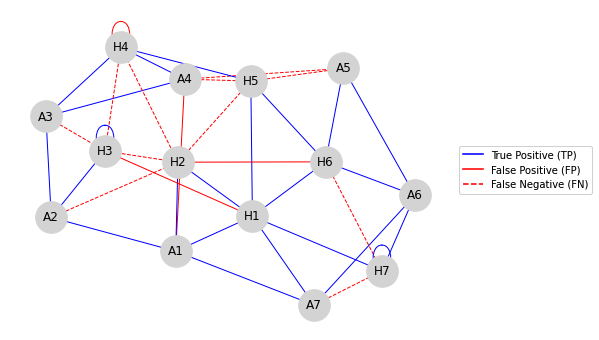

In [123]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the nodes and edges
nodes = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7']
predicted_edges = list(results.index)
actual_edges = ['A3_H4', 'H3_H3', 'H1_H7', 'A6_A7', 'A2_A3', 'A3_H3', 'A3_A4', 'H4_H5', 'A6_H7', 'A5_H6',
                'H5_H6', 'A2_H3', 'H1_H5', 'A1_H2', 'A2_H2', 'A5_A6', 'H1_H2', 'H1_H6', 'A1_A7', 'A1_H1',
                'H7_H7', 'A7_H7', 'A4_H5', 'H3_H4', 'A7_H1', 'A1_A2', 'H6_H7', 'H2_H3', 'A6_H6', 'H2_H5',
                'A4_H4', 'A5_H5', 'A4_A5', 'H2_H4']

# Create a graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(nodes)

# Add predicted edges as red lines
for edge in predicted_edges:
    if edge in actual_edges:
        G.add_edge(edge.split('_')[0], edge.split('_')[1], color='blue')  # True positive (blue line)
    else:
        G.add_edge(edge.split('_')[0], edge.split('_')[1], color='red')  # False positive (red line)

# Add actual edges as dashed red lines (false negatives)
for edge in actual_edges:
    if edge not in predicted_edges:
        G.add_edge(edge.split('_')[0], edge.split('_')[1], color='red', linestyle='dashed')  # False negative (dashed red line)

# Draw the graph using circular layout
pos = nx.spring_layout(G)
edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]
styles = [G[u][v]['linestyle'] if 'linestyle' in G[u][v] else 'solid' for u, v in edges]

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color=colors, style=styles)

# Create legend
true_positive = plt.Line2D([], [], color='blue', linestyle='-', label='True Positive (TP)')
false_positive = plt.Line2D([], [], color='red', linestyle='-', label='False Positive (FP)')
false_negative = plt.Line2D([], [], color='red', linestyle='dashed', label='False Negative (FN)')

# Move the legend outside of the graph
legend = plt.legend(handles=[true_positive, false_positive, false_negative], loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().add_artist(legend)

plt.axis('off')
plt.show()